# Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали.

Для уменьшения потребления электроэнергии на этапе обработке стали металлургическому комбинату необходимо построить модель, которая предскажет температуру стали.

## Описание этапа обработки стали

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат.

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.

## Описание данных
Данные состоят из файлов, полученных из разных источников:
- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. 

В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## План работы
0. Импорт библиотек
1.  Знакомство c данными и исследование данных
    
    * загрузка данных
    * исследование данных
        * изучение структуры данных (shape, info)
        * изучение содержимого данных (несколько строк)
        * изучение на предмет пропусков значений
        * проверка на наличие дубликатов
        * визуализация данных (при необходимости)
        * выявление аномалий 
        * проверка наличия корреляций (при необходмости)
2. Предобработка данных
    * обработка выбросов, аномалий
    * обработка пропусков
    * генерация новых признаков (при необходимости)
    * агрегирование данных по номеру партии
    * объединение в один датафрейм
    * исследование объединенного датафрейма
        * проверка наличия корреляций
3. Обучение и выбор лучшей модели
    * разбиение данных на обучающую и тестовую выборки
    * подбор гиперпараметров для нескольких моделей с кроссвалидацией и масштабированием (при необходимости) и определение лучшей
    * проверка качества выбранной лучшей модели на тестовой выборке
    * сравненние с константной моделью
    * исследование важности признаков
4. Отчет
    * сравнение решения и плана
    * описание трудностей проекта
    * ключевые шаги решения
    * признаки, которые использовали для обучения и их обработка
    * полное описание модели (с гиперпараметрами, включая random_state, если использовался)
    * итоговая метрика
    * рекомендации по улучшению решения

# 0. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.dummy import DummyRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
#from scipy.stats import randint

# настроим количество отображаемых столбцов при выводе в ноутбуке
pd.options.display.max_colwidth = 100

#константа для random_state
RND = 110923 

# Знакомство c данными и исследование данных 

## Загрузка данных

In [2]:
# загрузка данных
pth='datasets/'

# data_arc_new.csv — данные об электродах;
df_arc = pd.read_csv(pth + 'data_arc_new.csv') 

# data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
df_bulk = pd.read_csv(pth + 'data_bulk_new.csv') 

# data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
df_bulk_time = pd.read_csv(pth + 'data_bulk_time_new.csv')

# data_gas_new.csv — данные о продувке сплава газом;
df_gas = pd.read_csv(pth + 'data_gas_new.csv')

# data_temp_new.csv — результаты измерения температуры;
df_temp = pd.read_csv(pth + 'data_temp_new.csv')

# data_wire_new.csv — данные о проволочных материалах (объём);
df_wire = pd.read_csv(pth + 'data_wire_new.csv')

# data_wire_time_new.csv — данные о проволочных материалах (время).
df_wire_time = pd.read_csv(pth + 'data_wire_time_new.csv')

## Исследование данных

In [4]:
# функция для первичного ознакомления с данными 
def first_sight(df, describe=True):
    # Изучение структуры данных
    print('Размер датасета:', df.shape)  # Размерность данных (количество строк, количество столбцов)
    print()
    df.info()  # Общая информация о данных, включая типы столбцов и количество непустых значений
    print()
    
    # Изучение содержимого данных
    print('Первые строки датасета')
    display(df.head())  # Первые несколько строк данных
    if describe:
        print('Сводная статистика для числовых столбцов')
        display(df.describe())  # Сводная статистика для числовых столбцов
    
    # Определение пропущенных значений
    print('Пропуски')
    display(pd.DataFrame({'Пропущенные, шт': df.isna().sum(),
                                     'Пропущенные, %': df.isna().mean()*100}))
    
    # Проверка на дубликаты
    print('Количество полных дубликатов:', df.duplicated().sum())
    
    return

### df_arc — данные об электродах

In [5]:
first_sight(df_arc)

Размер датасета: (14876, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB

Первые строки датасета


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Сводная статистика для числовых столбцов


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Пропуски


,"Пропущенные, шт","Пропущенные, %"
key,0,0.0
Начало нагрева дугой,0,0.0
Конец нагрева дугой,0,0.0
Активная мощность,0,0.0
Реактивная мощность,0,0.0


Количество полных дубликатов: 0


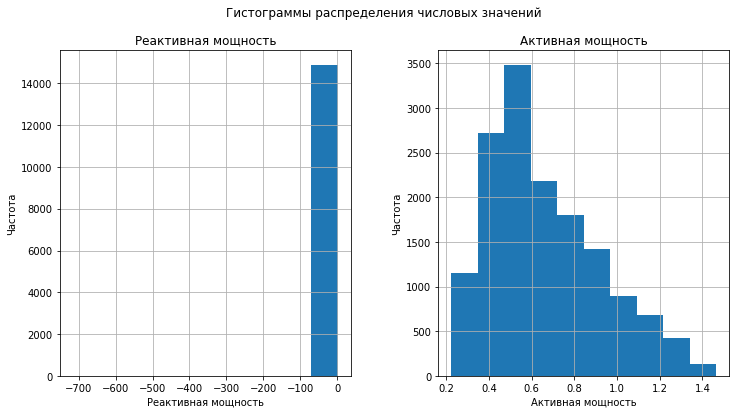

In [6]:
# Построение гистограмм для числовых столбцов
histos = df_arc[['Реактивная мощность', 'Активная мощность']].hist(figsize=(12,6))
plt.suptitle('Гистограммы распределения числовых значений')
for hist in histos[0]:
    hist.set_xlabel(hist.get_title())
    hist.set_ylabel('Частота')

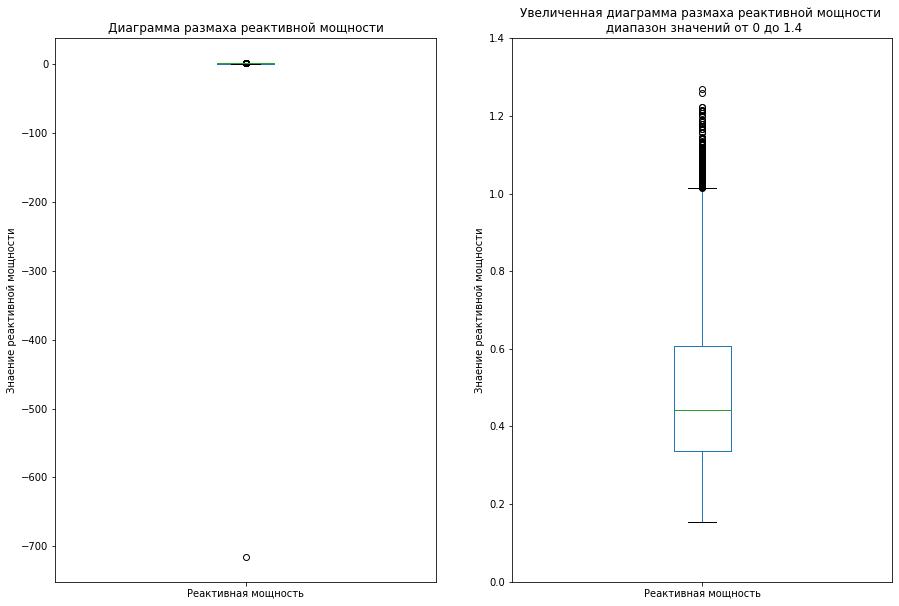

In [7]:
plt.figure(figsize=(15,10))
ax1=plt.subplot(121)
ax1=df_arc['Реактивная мощность'].plot.box()
ax1.set_title('Диаграмма размаха реактивной мощности')
ax1.set_ylabel('Знаение реактивной мощности')
ax2=plt.subplot(122)
ax2.set_title('Увеличенная диаграмма размаха реактивной мощности \n диапазон значений от 0 до 1.4')
ax2=df_arc['Реактивная мощность'].plot.box(ylim=(0, 1.4))
ax2.set_ylabel('Знаение реактивной мощности')

plt.show()

In [8]:
# записи с отрицательными мощностями
df_arc[df_arc['Реактивная мощность']<0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Присутствует отрицательная реактивная мощность - это ошибка. Обработаем аномалию на этапе предобработки.

Проверим корреляцию между активной мощностью и реактивной мощностью (исключив аномалию)

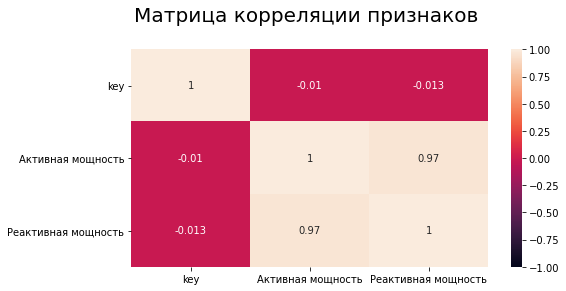

In [9]:
# корреляция между активной и реактивной мощностью без отрицательной реактивной мощности

plt.figure(figsize=(8,4))
ax = plt.axes()
sns.heatmap(
    df_arc[df_arc['Реактивная мощность']>0].corr(),        
    annot=True, # рисует значения внутри ячеек
    vmin=-1, vmax=1,  # указывает начало цветовых кодов от -1 до 1.
    ax = ax);
ax.set_title('Матрица корреляции признаков \n', fontsize=20)
plt.show()


Имеем сильную корреляцию активной и реактивной мощности - разумно использовать только активную мощность в качестве признака.

In [10]:
# количество итераций в партиях
df_arc.key.value_counts()

2108    16
1689    15
1513    15
2567    14
46      13
        ..
977      1
247      1
2582     1
248      1
530      1
Name: key, Length: 3214, dtype: int64

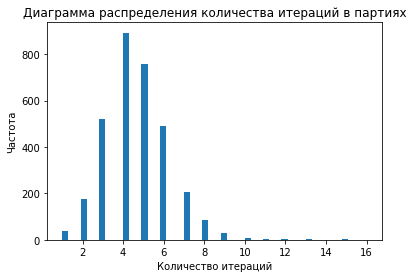

In [11]:
# диаграмма распределения количества итераций в партиях
df_arc.key.value_counts().plot(kind='hist', bins=50, title='Диаграмма распределения количества итераций в партиях')
plt.xlabel('Количество итераций')
plt.ylabel('Частота')
plt.show()

Подавляющее большинство партий проходят от 2 до 8 итераций. 

Чаще всего укладываются в 3-6 итераций до достижения результата. 

Максимально имеем 16 итераций. 

In [12]:
# количество партий металла в датасете
print('Количество партий металла в датасете', len(df_arc.key.value_counts()))

Количество партий металла в датасете 3214


Количество партий металла в датасете 3214, а номера партий от 1 до 3241 - значит данные по некоторым партиям отсутствуют.

#### Вывод по df_arc — данные об электродах. 
- Размер датасета: (14876, 5).
- Содержит данные по нагреву электродами каждой партии (время начала нагрева, время окончания нагрева, активная мощность, реактивная мощность).
- Пропуски отсутствуют
- Дубликаты отсутствуют
- В данных содержится одно аномальное значение реактивной мощности -715.479924 в партии 2116. В связи с сильной корреляцией с активной мощностью планируем использовать только активную мощность в признаках.
- Разные партии металла нагревали разное количество раз от 1 до 16, большую часть партий нагревали от 2 до 8 раз.
- Количество партий металла в датасете 3214, а номера партий от 1 до 3241 - значит данные по некоторым партиям отсутствуют.

### df_bulk — данные о подаче сыпучих материалов (объем)

In [13]:
first_sight(df_bulk)

Размер датасета: (3129, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB

Первые строки датасета


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Сводная статистика для числовых столбцов


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Пропуски


,"Пропущенные, шт","Пропущенные, %"
key,0,0.000000
Bulk 1,2877,91.946309
Bulk 2,3107,99.296900
Bulk 3,1831,58.517098
Bulk 4,2115,67.593480
Bulk 5,3052,97.539150
Bulk 6,2553,81.591563
Bulk 7,3104,99.201023
Bulk 8,3128,99.968041
Bulk 9,3110,99.392777


Количество полных дубликатов: 0


Присутствуют пропуски в данных. Пропуск означает отсутствие соответствующей примеси в партии металла.

Некоторые материалы подавались в малом количестве партий (до 25 партий металла):
- Bulk 2 - 22 партии
- Bulk 7 - 25 партий
- Bulk 8 - 1 партия
- Bulk 9 - 19 партий
- Bulk 13 - 18 партий

Использовать их в качестве признаков - нецелесообразно.

In [14]:
# количество партий металла в датасете
print('Количество партий металла в датасете', len(df_bulk.key.value_counts()))

Количество партий металла в датасете 3129


Количество партий в датасете равно количеству записей (3129 шт), номера партий от 1 до 3241 - значит данные о некоторых партиях отсутствуют. Количество партий в данном датасете отличается от количества партий в датасете с данными по электродам (3214 шт).

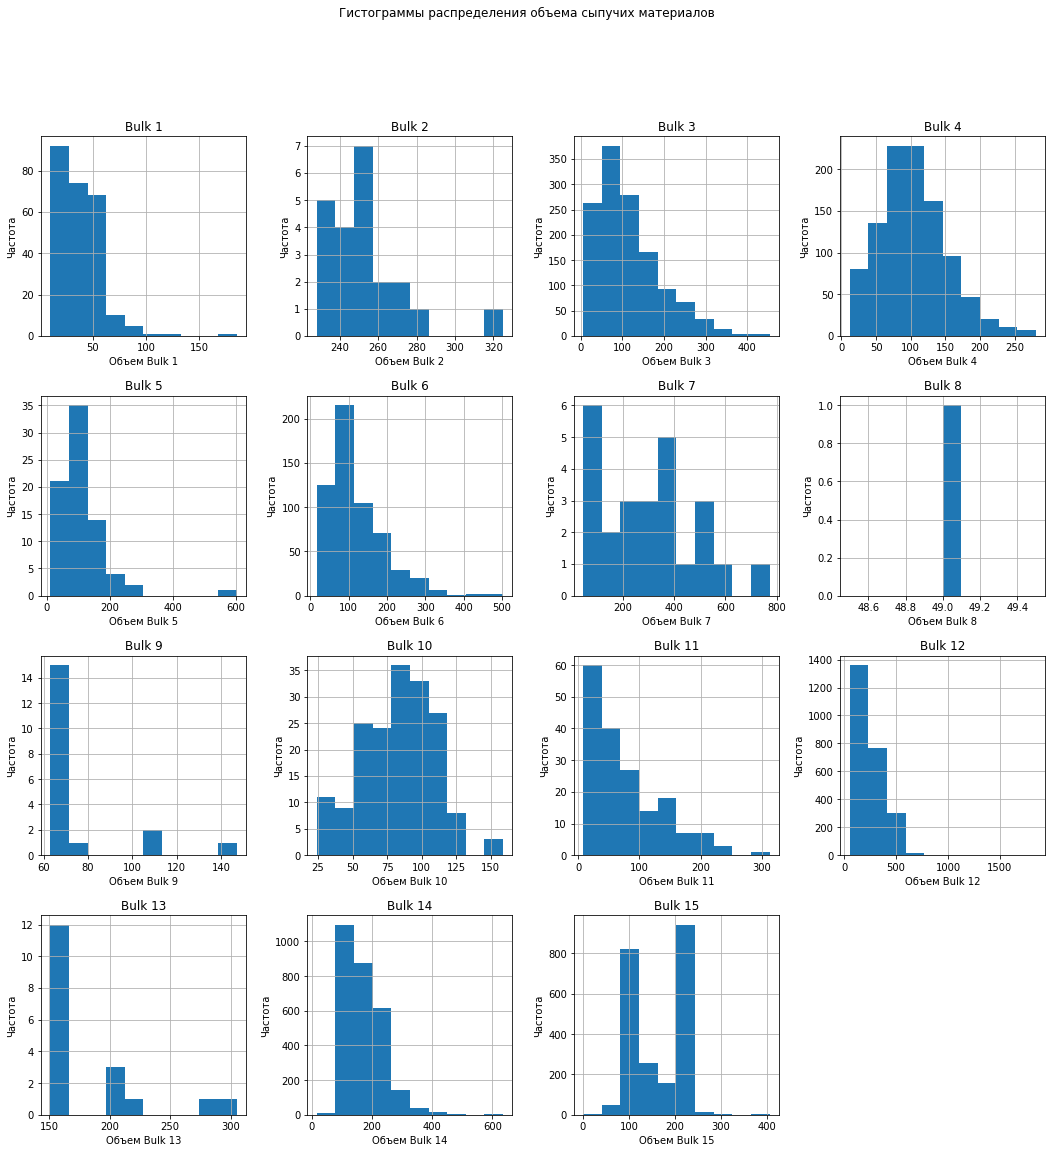

In [15]:
# Построение гистограмм для числовых столбцов
histos=df_bulk.loc[:, df_bulk.columns != 'key'].hist(figsize=(18,18))
plt.suptitle('Гистограммы распределения объема сыпучих материалов')
for hist_row in histos:
    for hist in hist_row:
        hist.set_xlabel('Объем ' + hist.get_title())
        hist.set_ylabel('Частота')

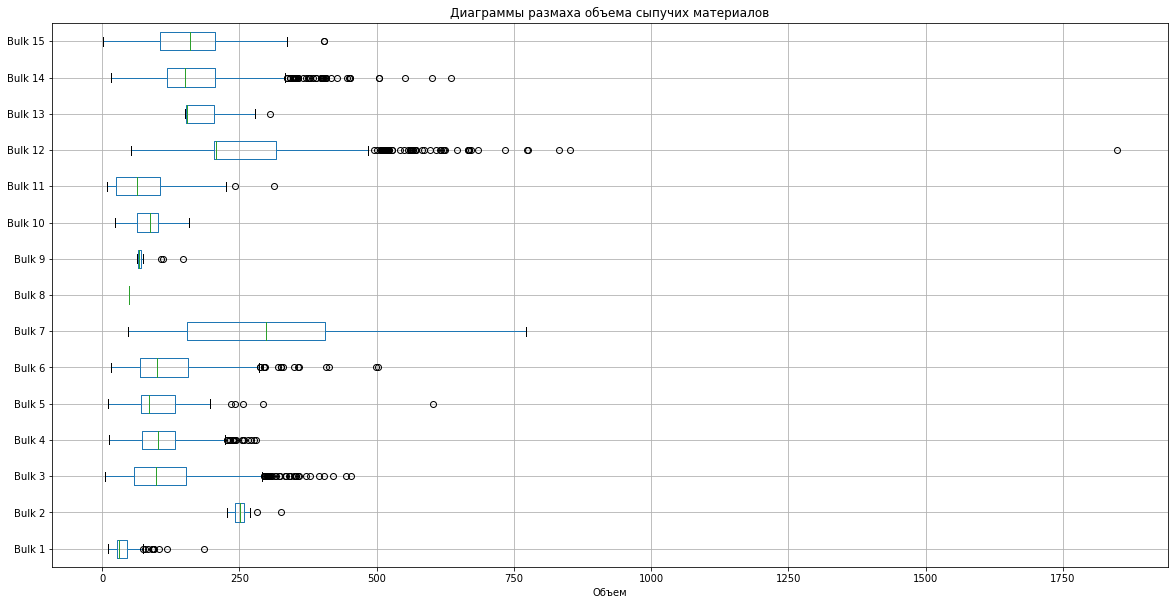

In [16]:
ax=df_bulk.loc[:, df_bulk.columns != 'key'].boxplot(figsize=(20,10), vert=False)
ax.set_title('Диаграммы размаха объема сыпучих материалов')
ax.set_xlabel('Объем');

Присутствуют выбросы в Bulk 5 (значение 603) и Bulk 12 (значение 1849) - требует уточнения у заказчика: это ошибочные значения или редкий случай бизнес-процесса?


#### Вывод по df_bulk — данные о подаче сыпучих материалов (объем)
- Размер датасета: (3129, 16).
- Содержит данные по объему подачи каждого из 15 видов сыпучих материалов в партию металла (столбцы Bulk 1 - Bulk 15).
- Пропуски имеются в столбцах Bulk 1 - Bulk 15 и означают отсутсвие соответствующего материала в партии металла. На этапе предобработки заменить на 0.
- Дубликаты отсутствуют.
- Некоторые материалы подавались в незанчительном количестве партий (до 25 партий металла):
    - Bulk 2 - 22 партии
    - Bulk 7 - 25 партий
    - Bulk 8 - 1 партия
    - Bulk 9 - 19 партий
    - Bulk 13 - 18 партий
    Не будем использовать их в качестве признаков 
- Аномалии: присутствуют одиночные выбросы в Bulk 5 (значение 603) и Bulk 12 (значение 1849) - требует уточнения у заказчика: это ошибочные значения или редкий случай бизнес-процесса?
- Количество партий металла в датасете 3129 шт, а номера партий от 1 до 3241 - значит данные по некоторым партиям отсутствуют. Количество партий в данном датасете отличается от количества партий в датасете с данными по электродам (3214 шт)

### df_bulk_time — данные о подаче сыпучих материалов (время)

In [17]:
first_sight(df_bulk_time, describe=False)

Размер датасета: (3129, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB

Первые строки датасета


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


Пропуски


,"Пропущенные, шт","Пропущенные, %"
key,0,0.000000
Bulk 1,2877,91.946309
Bulk 2,3107,99.296900
Bulk 3,1831,58.517098
Bulk 4,2115,67.593480
Bulk 5,3052,97.539150
Bulk 6,2553,81.591563
Bulk 7,3104,99.201023
Bulk 8,3128,99.968041
Bulk 9,3110,99.392777


Количество полных дубликатов: 0


In [18]:
# количество партий металла в датасете
print('Количество партий металла в датасете', len(df_bulk_time.key.value_counts()))

Количество партий металла в датасете 3129


Количество партий в датасете равно количеству записей (3129 шт), номера партий от 1 до 3241 - значит данные о некоторых партиях отсутствуют. Количество партий в данном датасете отличается от количества партий в датасете с данными по электродам (3214 шт).

In [19]:
# Преобразование даты и времени в datetime
dt_columns = set(df_bulk_time.columns) - {'key'}

for column in dt_columns:
    df_bulk_time[column] = pd.to_datetime(df_bulk_time[column])
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [20]:
df_bulk_time.agg(['min', 'max'])

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
min,1,2019-05-03 17:42:46,2019-05-07 15:39:35,2019-05-03 20:40:25,2019-05-03 11:28:48,2019-05-07 15:19:17,2019-05-03 19:09:15,2019-05-07 18:11:01,2019-07-08 17:14:53,2019-05-14 11:57:58,2019-05-06 07:54:02,2019-05-05 23:43:24,2019-05-03 11:24:31,2019-05-05 02:10:21,2019-05-03 11:14:50,2019-05-03 11:10:43
max,3241,2019-09-05 09:11:32,2019-08-13 11:47:39,2019-09-06 12:26:52,2019-09-05 03:35:21,2019-09-02 18:16:52,2019-09-06 16:24:28,2019-09-05 19:07:49,2019-07-08 17:14:53,2019-08-16 09:11:56,2019-09-04 10:03:22,2019-09-06 05:03:14,2019-09-06 15:01:44,2019-09-01 01:53:02,2019-09-06 17:26:33,2019-09-06 17:23:15


#### Вывод по df_bulk_time — данные о подаче сыпучих материалов (время)
- Размер датасета: (3129, 16).
- Содержит данные по времени подачи каждого из 15 видов  сыпучих материалов в партию металла (столбцы Bulk 1 - Bulk 15).
- Пропуски имеются в столбцах Bulk 1 - Bulk 15 и означают отсутствие соответствующего материала в партии металла.
- Дубликаты отсутствуют.
- аномальных значений нет.
- Количество партий металла в датасете 3129, а номера партий от 1 до 3241 - значит данные по некоторым партиям отсутствуют. Это соответсвует данным по объемам из df_bulk
- Даты и время подачи: с 2019-05-03 11:10:43 по 2019-09-06 17:26:33

### df_gas — данные о продувке сплава газом

In [21]:
first_sight(df_gas)

Размер датасета: (3239, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

Первые строки датасета


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Сводная статистика для числовых столбцов


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Пропуски


,"Пропущенные, шт","Пропущенные, %"
key,0,0.0
Газ 1,0,0.0


Количество полных дубликатов: 0


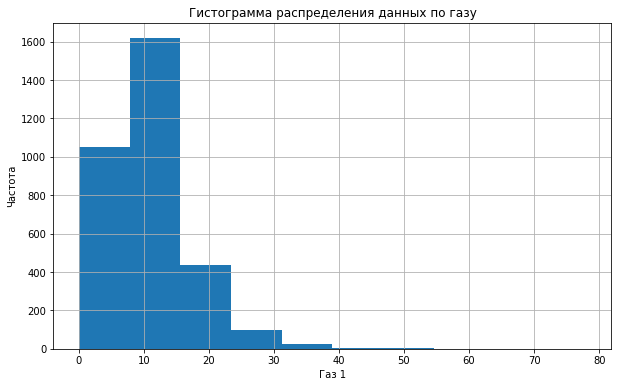

In [22]:
# Построение гистограмм для числовых столбцов
df_gas['Газ 1'].hist(figsize=(10,6))
plt.title('Гистограмма распределения данных по газу')
plt.xlabel('Газ 1')
plt.ylabel('Частота')
plt.show()

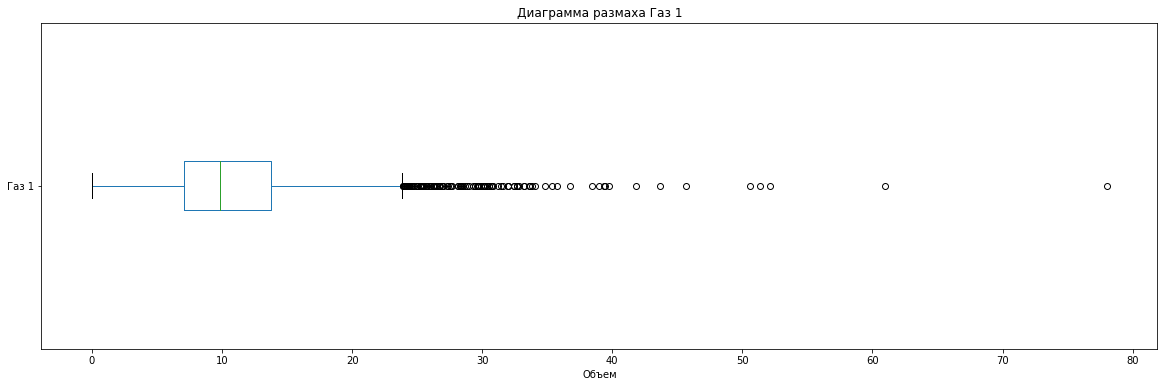

In [23]:
df_gas['Газ 1'].plot(kind='box', figsize=(20,6), vert=False)
plt.title('Диаграмма размаха Газ 1')
plt.xlabel('Объем')
plt.show()

In [24]:
print('Количество партий металла в датасете', len(df_gas.key.value_counts()))

Количество партий металла в датасете 3239


#### Вывод по df_gas — данные о продувке сплава газом
- Размер датасета: (3239, 2)
- Содержит столбцы: 'key' (номер партии),  'Газ 1' (характеристика продувки газом).
- Пропуски отсутствуют
- Дубликаты отсутствуют.
- Есть выбросы - значения более 50. Уточнить у заказчкиа - это часть бизнес процесса или ошибка.
- Количество партий металла в датасете 3239, а номера партий от 1 до 3241 - значит данные по некоторым партиям отсутствуют. 

### df_temp — результаты измерения температуры

In [25]:
first_sight(df_temp)

Размер датасета: (18092, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB

Первые строки датасета


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Сводная статистика для числовых столбцов


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


Пропуски


,"Пропущенные, шт","Пропущенные, %"
key,0,0.000000
Время замера,0,0.000000
Температура,3427,18.942074


Количество полных дубликатов: 0


In [26]:
df_temp[df_temp['key'] < 3]

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


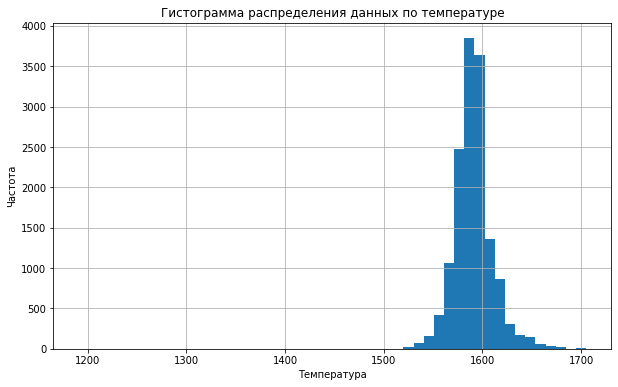

In [27]:
# Построение гистограмм для числовых столбцов
df_temp['Температура'].hist(figsize=(10,6), bins=50)
plt.title('Гистограмма распределения данных по температуре')
plt.xlabel('Температура')
plt.ylabel('Частота')
plt.show()

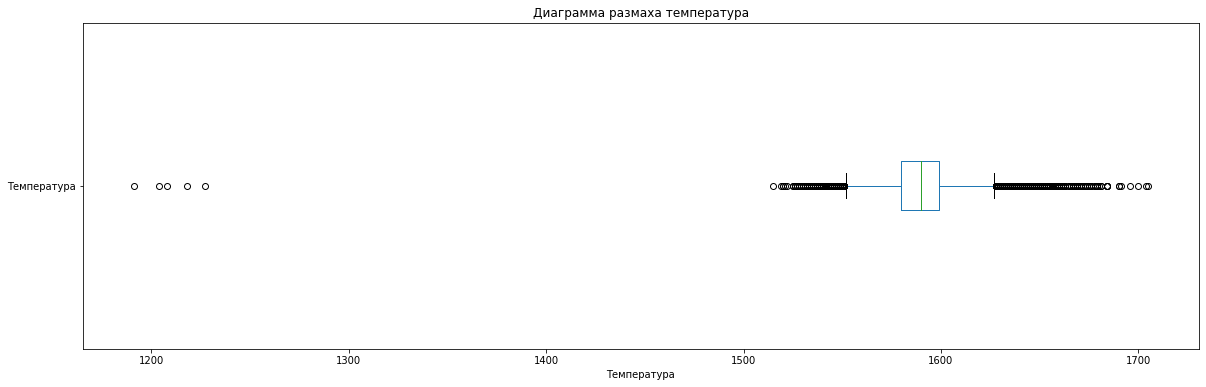

In [28]:
df_temp['Температура'].plot(kind='box', figsize=(20,6), vert=False)
plt.title('Диаграмма размаха температура')
plt.xlabel('Температура')
plt.show()

In [29]:
print('Количество партий металла в датасете', len(df_temp.key.value_counts()))

Количество партий металла в датасете 3216


In [30]:
# Преобразование даты и времени в datetime
df_temp['Время замера'] = pd.to_datetime(df_temp['Время замера'])
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [31]:
df_temp.agg(['min', 'max'])

,key,Время замера,Температура
min,1,2019-05-03 11:02:04,1191.0
max,3241,2019-09-06 17:30:05,1705.0


#### Вывод по df_temp — результаты измерения температуры
- Размер датасета: (18092, 3)
- Содержит столбцы: 'key' (номер партии),  'Время замера', 'Температура'. 
- Содержит данные о последовательных замерах температуры с 1 партии 2019-05-03 11:02:04 по 3241 партию 2019-09-06 17:30:05
- Пропуски присустствуют в замерах температуры
- Дубликаты отсутствуют.
- Присутствуют ошибки измерения - темпертаура меньше 1300 - удалить эти записи на этапе предобработки.
- Количество партий металла в датасете 3216, а номера партий от 1 до 3241 - данные по некоторым партиям отсутствуют. 

### df_wire — данные о проволочных материалах (объём)

In [32]:
first_sight(df_wire)

Размер датасета: (3081, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

Первые строки датасета


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Сводная статистика для числовых столбцов


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Пропуски


,"Пропущенные, шт","Пропущенные, %"
key,0,0.000000
Wire 1,26,0.843882
Wire 2,2002,64.978903
Wire 3,3018,97.955209
Wire 4,3067,99.545602
Wire 5,3080,99.967543
Wire 6,3008,97.630639
Wire 7,3070,99.642973
Wire 8,3062,99.383317
Wire 9,3052,99.058747


Количество полных дубликатов: 0


Присутствуют пропуски в данных. Пропуск означает отсутствие соответствующего проволочного материала в партии металла.

Некоторые проволочные материалы подавались в малом количестве партий (менее чем в 30 партиях металла):
- Wire 4 - 14 партий
- Wire 5 - 1 партия
- Wire 7 - 11 партий
- Wire 8 - 19 партий
- Wire 9 - 29 партий

Использовать их в качестве признаков - нецелесообразно.

In [33]:
# количество партий металла в датасете
print('Количество партий металла в датасете', len(df_wire.key.value_counts()))

Количество партий металла в датасете 3081


Количество партий в датасете равно количеству записей (3081 шт), номера партий от 1 до 3241 - значит данные о некоторых партиях отсутствуют. 

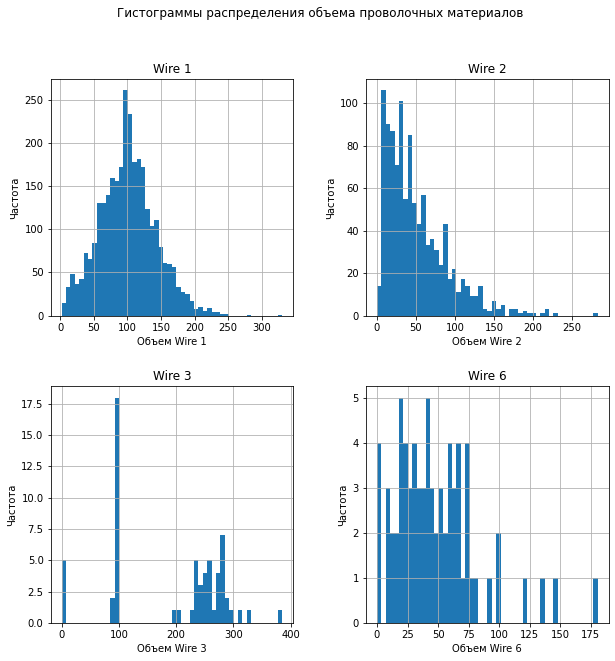

In [34]:
# Построение гистограмм для числовых столбцов
histos = df_wire[['Wire 1', 'Wire 2', 'Wire 3', 'Wire 6']].hist(figsize=(10,10), bins=50)
plt.suptitle('Гистограммы распределения объема проволочных материалов')
for hist_row in histos:
    for hist in hist_row:
        hist.set_xlabel('Объем ' + hist.get_title())
        hist.set_ylabel('Частота');

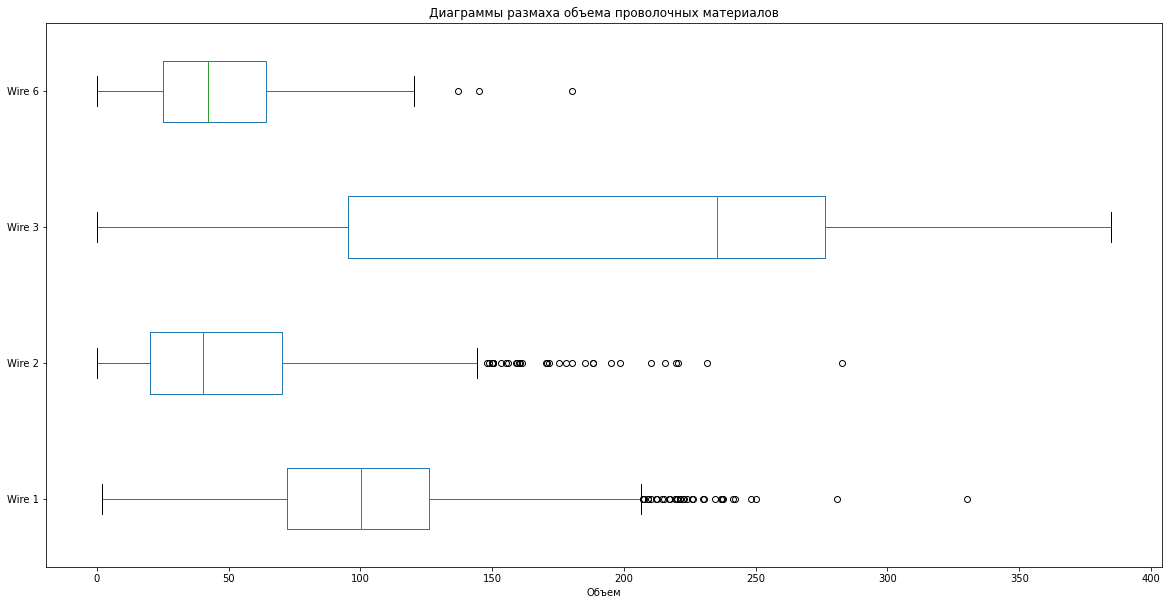

In [35]:
ax=df_wire[['Wire 1', 'Wire 2', 'Wire 3', 'Wire 6']].plot(kind='box', figsize=(20,10), vert=False)
ax.set_title('Диаграммы размаха объема проволочных материалов')
plt.xlabel('Объем');

Присутствуют выбросы:
- Wire 1 (значения от 250 до 330),
- Wire 2 (значение от 200 до 283),
- Wire 6 (значение от 125 до 180)

Требует уточнения у заказчика: это ошибочные значения или редкий случай бизнес-процесса?


#### Вывод по df_wire — данные о подаче сыпучих материалов (объем)
- Размер датасета: (3081, 10).
- Содержит данные по объему подачи каждого из 9 видов проволочных материалов в партию металла (столбцы Wire 1 - Wire 9).
- Пропуски имеются в столбцах Wire 1 - Wire 9 и означают отсутствие соответствующего материала в партии металла. На этапе предобработки заменить на 0.
- Дубликаты отсутствуют.
- Некоторые материалы подавались в незначительном количестве партий (менее чем в 30 партиях металла):
    - Wire 4 - 14 партий
    - Wire 5 - 1 партия
    - Wire 7 - 11 партий
    - Wire 8 - 19 партий
    - Wire 9 - 29 партий
    Не будем использовать их в качестве признаков 
- Аномалии: присутствуют одиночные выбросы:
    - Wire 1 (значения от 250 до 330),
    - Wire 2 (значение от 200 до 283),
    - Wire 6 (значение от 125 до 180)    
    
    Требует уточнения у заказчика: это ошибочные значения или редкий случай бизнес-процесса?
- Количество партий металла в датасете 3081 шт, а номера партий от 1 до 3241 - значит данные по некоторым партиям отсутствуют.

### df_wire_time — данные о проволочных материалах (время)

In [36]:
first_sight(df_wire_time)

Размер датасета: (3081, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB

Первые строки датасета


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Сводная статистика для числовых столбцов


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Пропуски


,"Пропущенные, шт","Пропущенные, %"
key,0,0.000000
Wire 1,26,0.843882
Wire 2,2002,64.978903
Wire 3,3018,97.955209
Wire 4,3067,99.545602
Wire 5,3080,99.967543
Wire 6,3008,97.630639
Wire 7,3070,99.642973
Wire 8,3062,99.383317
Wire 9,3052,99.058747


Количество полных дубликатов: 0


In [37]:
# количество партий металла в датасете
print('Количество партий металла в датасете', len(df_wire_time.key.value_counts()))

Количество партий металла в датасете 3081


Количество партий в датасете равно количеству записей (3081 шт), номера партий от 1 до 3241 - значит данные о некоторых партиях отсутствуют.

In [38]:
# Преобразование даты и времени в datetime
dt_columns = set(df_wire_time.columns) - {'key'}

for column in dt_columns:
    df_wire_time[column] = pd.to_datetime(df_wire_time[column])
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


In [39]:
df_wire_time.agg(['min', 'max'])

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
min,1,2019-05-03 11:06:19,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
max,3241,2019-09-06 17:10:06,2019-09-06 07:35:40,2019-09-02 07:14:44,2019-08-13 03:16:45,2019-08-13 06:14:30,2019-08-18 19:10:56,2019-08-13 10:25:22,2019-08-16 08:56:23,2019-09-03 12:55:23


#### Вывод по df_bulk_time — данные о подаче сыпучих материалов (время)
- Размер датасета: (3081, 10).
- Содержит данные по времени подачи каждого из 9 видов проволочных материалов в партию металла (столбцы Wire 1 - Wire 9).
- Пропуски имеются в столбцах Wire 1 - Wire 9 и означают отсутствие соответствующего материала в партии металла.
- Дубликаты отсутствуют.
- аномальных значений нет.
- Количество партий металла в датасете 3081, а номера партий от 1 до 3241 - значит данные по некоторым партиям отсутствуют. Это соответсвует данным по объемам из df_wire
- Даты и время подачи: с 2019-05-03 11:06:19 по 2019-09-06 07:35:40

### Вывод по знакомству с данными и исследованию данных
   
### df_arc  — данные об электродах
- Размер датасета: (14876, 5).
- Содержит данные по нагреву электродами каждой партии (время начала нагрева, время окончания нагрева, активная мощность, реактивная мощность).
- Пропуски отсутствуют
- Дубликаты отсутствуют
- В данных содержится одно аномальное значение реактивной мощности -715.479924 в партии 2116. В связи с сильной корреляцией с активной мощностью - планируем не использовать в признаках реактивную мощность.
- Разные партии металла нагревали разное количество раз от 1 до 16, большую часть партий нагревали от 2 до 8 раз.
- Количество партий металла в датасете 3214, а номера партий от 1 до 3241 - значит данные по некоторым партиям отсутствуют.

### df_bulk — данные о подаче сыпучих материалов (объём)
- Размер датасета: (3129, 16).
- Содержит данные по объему подачи каждого из 15 видов сыпучих материалов в партию металла (столбцы Bulk 1 - Bulk 15).
- Пропуски имеются в столбцах Bulk 1 - Bulk 15 и означают отсутсвие соответствующего материала в партии металла. На этапе предобработки заменить на 0.
- Дубликаты отсутствуют.
- Некоторые материалы подавались в незанчительном количестве партий (до 25 партий металла):
    - Bulk 2 - 22 партии
    - Bulk 7 - 25 партий
    - Bulk 8 - 1 партия
    - Bulk 9 - 19 партий
    - Bulk 13 - 18 партий
    
    Не будем использовать их в качестве признаков 
- Аномалии: присутствуют одиночные выбросы в Bulk 5 (значение 603) и Bulk 12 (значение 1849) - требует уточнения у заказчика: это ошибочные значения или редкий случай бизнес-процесса?
- Количество партий металла в датасете 3129 шт, а номера партий от 1 до 3241 - значит данные по некоторым партиям отсутствуют. Количество партий в данном датасете отличается от количества партий в датасете с данными по электродам (3214 шт)

### df_bulk_time — данные о подаче сыпучих материалов (время)
- Размер датасета: (3129, 16).
- Содержит данные по времени подачи каждого из 15 видов  сыпучих материалов в партию металла (столбцы Bulk 1 - Bulk 15).
- Пропуски имеются в столбцах Bulk 1 - Bulk 15 и означают отсутствие соответствующего материала в партии металла.
- Дубликаты отсутствуют.
- аномальных значений нет.
- Количество партий металла в датасете 3129, а номера партий от 1 до 3241 - значит данные по некоторым партиям отсутствуют. Это соответсвует данным по объемам из df_bulk
- Даты и время подачи: с 2019-05-03 11:10:43 по 2019-09-06 17:26:33

### df_gas — данные о продувке сплава газом
- Размер датасета: (3239, 2)
- Содержит столбцы: 'key' (номер партии),  'Газ 1' (характеристика продувки газом).
- Пропуски отсутствуют
- Дубликаты отсутствуют.
- Есть выбросы - значения более 50. Уточнить у заказчкиа - это часть бизнес процесса или ошибка?
- Количество партий металла в датасете 3239, а номера партий от 1 до 3241 - значит данные по некоторым партиям отсутствуют. 

### df_temp — результаты измерения температуры
- Размер датасета: (18092, 3)
- Содержит столбцы: 'key' (номер партии),  'Время замера', 'Температура'. 
- Содержит данные о последовательных замерах температуры с 1 партии 2019-05-03 11:02:04 по 3241 партию 2019-09-06 17:30:05
- Пропуски присутствуют в замерах температуры
- Дубликаты отсутствуют.
- Присутствуют ошибки измерения - темпертаура меньше 1300 - удалить эти записи на этапе предобработки.
- Количество партий металла в датасете 3216, а номера партий от 1 до 3241 - данные по некоторым партиям отсутствуют. 

### df_wire — данные о проволочных материалах (объём)
- Размер датасета: (3081, 10).
- Содержит данные по объему подачи каждого из 9 видов проволочных материалов в партию металла (столбцы Wire 1 - Wire 9).
- Пропуски имеются в столбцах Wire 1 - Wire 9 и означают отсутствие соответствующего материала в партии металла. На этапе предобработки заменить на 0.
- Дубликаты отсутствуют.
- Некоторые материалы подавались в незначительном количестве партий (менее чем в 30 партиях металла):
    - Wire 4 - 14 партий
    - Wire 5 - 1 партия
    - Wire 7 - 11 партий
    - Wire 8 - 19 партий
    - Wire 9 - 29 партий
    Не будем использовать их в качестве признаков 
- Аномалии: присутствуют одиночные выбросы:
    - Wire 1 (значения от 250 до 330),
    - Wire 2 (значение от 200 до 283),
    - Wire 6 (значение от 125 до 180)    
    
    Требует уточнения у заказчика: это ошибочные значения или редкий случай бизнес-процесса?
- Количество партий металла в датасете 3081 шт, а номера партий от 1 до 3241 - значит данные по некоторым партиям отсутствуют.
### df_wire_time — данные о проволочных материалах (время)
- Размер датасета: (3081, 10).
- Содержит данные по времени подачи каждого из 9 видов проволочных материалов в партию металла (столбцы Wire 1 - Wire 9).
- Пропуски имеются в столбцах Wire 1 - Wire 9 и означают отсутствие соответствующего материала в партии металла.
- Дубликаты отсутствуют.
- аномальных значений нет.
- Количество партий металла в датасете 3081, а номера партий от 1 до 3241 - значит данные по некоторым партиям отсутствуют. Это соответсвует данным по объемам из df_wire
- Даты и время подачи: с 2019-05-03 11:06:19 по 2019-09-06 07:35:40


# Предобработка данных

Прежде чем начнем предобработку следует определиться с признаками и таргетами. 

В качестве таргета выступает последняя измеренная темпертаура по партии металла из df_temp.

В качестве признаков возьмем следующие:
- df_arc: энергрию затраченную на нагрев (активная мощность * время нагрева), время нагрева, количество нагревов
- df_bulk: 'Bulk 1', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 14', 'Bulk 15'
- df_bulk_time: время подачи сыпучих материалов нам не нужно - отсюда признаков не будет
- df_gas: 'Газ 1'
- df_temp: первая измеренная температура по партии металла
- df_wire: 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 6'
- df_wire_time: время подачи проволки нам не нужно - отсюда признаков не будет.

Проведем предобработку по каждому датафрейму:
   * обработка выбросов (аномалий)
   * обработка пропусков
   * генерация новых признаков (при необходимости)
   * агрегирование данных по номеру партии

Затем:
   * объединение в один датафрейм
   * исследование объединенного датафрейма
   * проверка наличия корреляций 

## df_arc предобработка

In [40]:
# Преобразование даты и времени в datetime
dt_columns = ['Начало нагрева дугой','Конец нагрева дугой']

for column in dt_columns:
    df_arc[column] = pd.to_datetime(df_arc[column])
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [41]:
df_arc[df_arc['Реактивная мощность']<0][['Активная мощность', 'Реактивная мощность']]

,Активная мощность,Реактивная мощность
9780,0.705344,-715.479924


Заменим отрицательную реактивную мощность на среднее значение реактивных мощностей, соответствующих активным мощностям находящимся в диапазоне +- 0.001 от известной активной мощности той записи, где находится отрицательная реактивная мощность

In [42]:
df_arc.loc[9780:9780, 'Реактивная мощность'] = df_arc[(df_arc['Активная мощность'] > (0.705344-0.001)) &
                                                                          (df_arc['Активная мощность'] < (0.705344+0.001)) &
                                                                          (df_arc['Реактивная мощность'] > 0)]['Реактивная мощность'].mean()


Вычислим и добавим новые признаки энергия (energy), время нагрева (duration) и количество нагревов (heating_count)

In [43]:
df_arc['duration'] = df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой']
df_arc['duration'] = df_arc['duration'].dt.total_seconds()
df_arc['energy'] = ((df_arc['Активная мощность']**2) + (df_arc['Реактивная мощность']**2))**0.5 * df_arc['duration']
display(df_arc.head())
df_arc['heating_count'] = 1
df_arc_1 = df_arc[['key','energy', 'duration', 'heating_count']].groupby('key').sum()
print('Размер датасета', df_arc_1.shape, '\n')
df_arc_1.info()
df_arc_1.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,duration,energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,159.830252


Размер датасета (3214, 3) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   energy         3214 non-null   float64
 1   duration       3214 non-null   float64
 2   heating_count  3214 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 100.4 KB


,energy,duration,heating_count
key,,,
1,770.282114,1098.0,5
2,481.760005,811.0,4
3,722.837668,655.0,5
4,683.455597,741.0,4
5,512.169934,869.0,4


### вывод df_arc предобработка
- аномалия (отрицательная реактивная мощность -715.479924) восстановлена по средней реактивных мощностей записей в которых активная мощность лежит в диапазоне +- 0,001 от активной мощности записи с аномальным значением реактивной. 
- пропуски отсутствовали
- сформированы новые признаки: 
    - энергия (energy) - произведение полной мощности (корень квадратный из суммы квадратов активной и реактивной мощности) на длительность нагрева)
    - длительность нагрева (duration)
    - количество нагревов (heating_count)
- данные агрегированы по номеру партии (суммарная энергия на каждую партию) и сформирован датасет (df_arc_1) со столбцами: 
    - номер партии (key)
    - энергия (energy)
    - длительность нагрева (duration)
    - количество нагревов (heating_count)

## df_bulk предобработка

In [44]:
df_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Удалим малозначимые сыпучие материалы, использованные в малом количестве партий:
  - Bulk 2 - 22 партии
  - Bulk 7 - 25 партий
  - Bulk 8 - 1 партия
  - Bulk 9 - 19 партий
  - Bulk 13 - 18 партий
  
  Заполним пропуски нулями

In [45]:
df_bulk_1 = df_bulk[['key', 'Bulk 1', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 14', 'Bulk 15']]
# df_bulk_1 = df_bulk
df_bulk_1 = df_bulk_1.fillna(0)
print('Размер датасета', df_bulk_1.shape, '\n')
df_bulk_1.info()
df_bulk_1.head()

Размер датасета (3129, 11) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 3   3129 non-null   float64
 3   Bulk 4   3129 non-null   float64
 4   Bulk 5   3129 non-null   float64
 5   Bulk 6   3129 non-null   float64
 6   Bulk 10  3129 non-null   float64
 7   Bulk 11  3129 non-null   float64
 8   Bulk 12  3129 non-null   float64
 9   Bulk 14  3129 non-null   float64
 10  Bulk 15  3129 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 269.0 KB


,key,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
0,1,0.0,0.0,43.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0
1,2,0.0,0.0,73.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0
2,3,0.0,0.0,34.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0
3,4,0.0,0.0,81.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0
4,5,0.0,0.0,78.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0


### вывод df_bulk предобработка

- аномалий нет
- пропуски заполнены нулями
- удалены малозначимые партии (использованные в менее чем 26 партиях металла):
  - Bulk 2 - 22 партии
  - Bulk 7 - 25 партий
  - Bulk 8 - 1 партия
  - Bulk 9 - 19 партий
  - Bulk 13 - 18 партий. 
- Сформирован новый датасет (df_bulk_1) с признаками: 'key', 'Bulk 1', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 14', 'Bulk 15'


## df_temp предобработка

Удалим партии с пропусками хотя бы в одном измерении, т.к. по информации от заказчика отсутствие измерений - ошибка.

Также, удалим партии, в которых присутствует только один замер температуры.

In [46]:
df_temp.tail(15)

,key,Время замера,Температура
18077,3239,2019-09-06 14:59:25,NaN
18078,3239,2019-09-06 15:03:35,NaN
18079,3239,2019-09-06 15:09:55,NaN
18080,3240,2019-09-06 15:25:21,1617.0
18081,3240,2019-09-06 15:30:52,NaN
18082,3240,2019-09-06 15:58:35,NaN
18083,3240,2019-09-06 16:02:31,NaN
18084,3240,2019-09-06 16:21:44,NaN
18085,3240,2019-09-06 16:35:26,NaN
18086,3241,2019-09-06 16:48:55,1586.0


In [47]:
# Удалить записи с одинаковым номером партии, если есть пропуски в столбце 'Температура'
keys_with_nans = df_temp[df_temp['Температура'].isna()]['key'].unique()
df_temp_1 = df_temp.query('key not in @keys_with_nans')

# Удалить записи, в которых только один замер температуры (номер партии не повторяется)
df_temp_1 = df_temp_1[df_temp_1.duplicated(subset='key', keep=False)]

df_temp_1.info()
df_temp_1.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13924 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13924 non-null  int64         
 1   Время замера  13924 non-null  datetime64[ns]
 2   Температура   13924 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 435.1 KB


,key,Время замера,Температура
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0
13925,2499,2019-08-10 13:58:58,1603.0


In [48]:
print('Количество партий после удаления партий с пропусками измерения температуры, а также с единичными замерами', df_temp_1.value_counts('key').sum())

Количество партий после удаления партий с пропусками измерения температуры, а также с единичными замерами 13924


Удалим партии с аномалиями в измерениях температуры (для нашего датасета можно взять <1300), т.к. по информации от заказчика это ошибки

In [49]:
keys_temp_less_1300 = df_temp_1[df_temp_1['Температура'] <= 1300]['key']
df_temp_1 = df_temp_1.query('key not in @keys_temp_less_1300')
df_temp_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13903 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13903 non-null  int64         
 1   Время замера  13903 non-null  datetime64[ns]
 2   Температура   13903 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 434.5 KB


По каждой партии оставим только первый и последний замер температуры.

In [50]:
df_temp_1.sort_values(['key', 'Время замера'], ascending=True)
first_last_temp = {'Температура': ['first', 'last']}
df_temp_1 = df_temp_1.groupby('key', as_index=False).agg(first_last_temp)
df_temp_1.columns = ['key','first_temperature','last_temperature']
df_temp_1.info()
df_temp_1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 0 to 2470
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2471 non-null   int64  
 1   first_temperature  2471 non-null   float64
 2   last_temperature   2471 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 77.2 KB


,key,first_temperature,last_temperature
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


### вывод df_temp предобработка
- Удалили партии с ошибками измерения температуры (температура < 1300)
- Удалили партии с пропусками в измерении температуры и единичными замерами
- Агрегировали по номеру партии и оставили только первый и последний замеры температуры - получили датасет df_temp_1 с признаками:
    - номер партии (key)
    - первая температура (first_temperature)
    - последняя температура (last_temperature)

## df_wire предобработка

In [51]:
df_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Удалим малоиспользуемые проволоки. Оставим 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 6'. Пропуски заменим нулями.

In [52]:
df_wire_1 = df_wire[['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 6']]
# df_wire_1 = df_wire
df_wire_1 = df_wire_1.fillna(0)
print('Размер датасета', df_wire_1.shape, '\n')
df_wire_1.info()
df_wire_1.head()

Размер датасета (3081, 5) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 6  3081 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 120.5 KB


,key,Wire 1,Wire 2,Wire 3,Wire 6
0,1,60.059998,0.00000,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0


### вывод df_wire предобработка

- аномалий нет
- пропуски заменены нулями
- сформирован новый датасет df_wire_1 с признаками: 'key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 6'


## Объединение датасетов

Объединим датасеты по номеру партии. Используем слияние inner - в объединенном датасете будут только те данные номер партии которых присутствует во всех датасетах.

In [53]:
df = df_arc_1.merge(df_bulk_1, how= 'inner', on='key').\
              merge(df_temp_1, how= 'inner', on='key').\
              merge(df_gas, how= 'inner', on='key').\
              merge(df_wire_1, how= 'inner', on='key')
df = df.drop('key', axis=1)

In [54]:
print('Размер датасета', df.shape, '\n')
df.info()
df.head()

Размер датасета (2325, 20) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   energy             2325 non-null   float64
 1   duration           2325 non-null   float64
 2   heating_count      2325 non-null   int64  
 3   Bulk 1             2325 non-null   float64
 4   Bulk 3             2325 non-null   float64
 5   Bulk 4             2325 non-null   float64
 6   Bulk 5             2325 non-null   float64
 7   Bulk 6             2325 non-null   float64
 8   Bulk 10            2325 non-null   float64
 9   Bulk 11            2325 non-null   float64
 10  Bulk 12            2325 non-null   float64
 11  Bulk 14            2325 non-null   float64
 12  Bulk 15            2325 non-null   float64
 13  first_temperature  2325 non-null   float64
 14  last_temperature   2325 non-null   float64
 15  Газ 1              2325 non-null   float64


,energy,duration,heating_count,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,first_temperature,last_temperature,Газ 1,Wire 1,Wire 2,Wire 3,Wire 6
0,770.282114,1098.0,5,0.0,0.0,43.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0,1571.0,1613.0,29.749986,60.059998,0.00000,0.0,0.0
1,481.760005,811.0,4,0.0,0.0,73.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0,1581.0,1602.0,12.555561,96.052315,0.00000,0.0,0.0
2,722.837668,655.0,5,0.0,0.0,34.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0,1596.0,1599.0,28.554793,91.160157,0.00000,0.0,0.0
3,683.455597,741.0,4,0.0,0.0,81.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0,1601.0,1625.0,18.841219,89.063515,0.00000,0.0,0.0
4,512.169934,869.0,4,0.0,0.0,78.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0,1576.0,1602.0,5.413692,89.238236,9.11456,0.0,0.0


### вывод объединение датасетов
Объединили датасеты в один датасет (df) с признаками:
- energy             
- duration           
- heating_count       
- Bulk 1             
- Bulk 3            
- Bulk 4             
- Bulk 5             
- Bulk 6             
- Bulk 10            
- Bulk 11            
- Bulk 12            
- Bulk 14            
- Bulk 15            
- first_temperature  
- last_temperature   
- Газ 1              
- Wire 1             
- Wire 2             
- Wire 3             
- Wire 6             

## Исследование объединенного датасета

Посмотрим на корреляцию признаков объединенного датасета

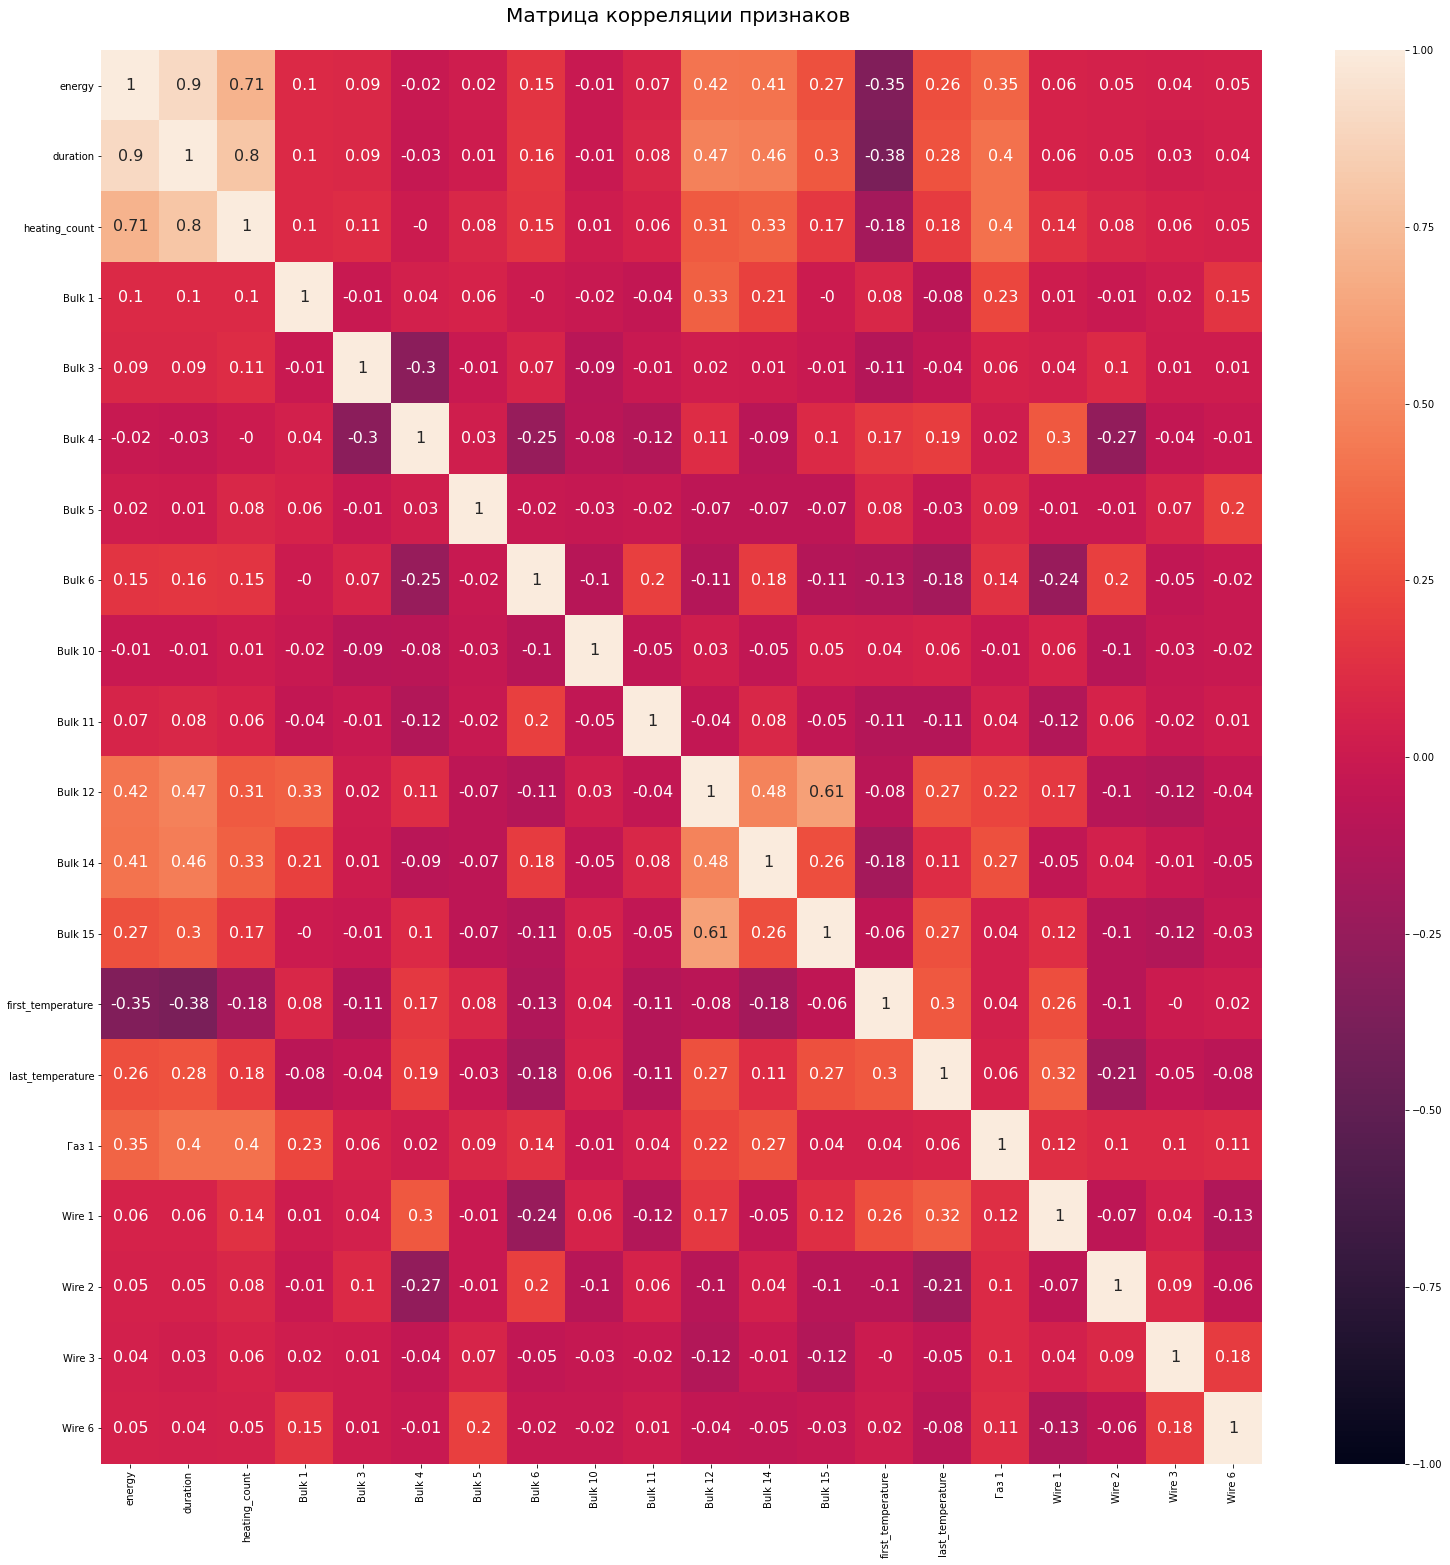

In [55]:
# корреляция
plt.figure(figsize=(26,26))
ax = plt.axes()
sns.heatmap(
    round(df.corr(),2),        
    annot=True, # рисует значения внутри ячеек
    annot_kws={"fontsize":16},
    vmin=-1, vmax=1,  # указывает начало цветовых кодов от -1 до 1.
    ax = ax);
ax.set_title('Матрица корреляции признаков \n', fontsize=20)
plt.show()

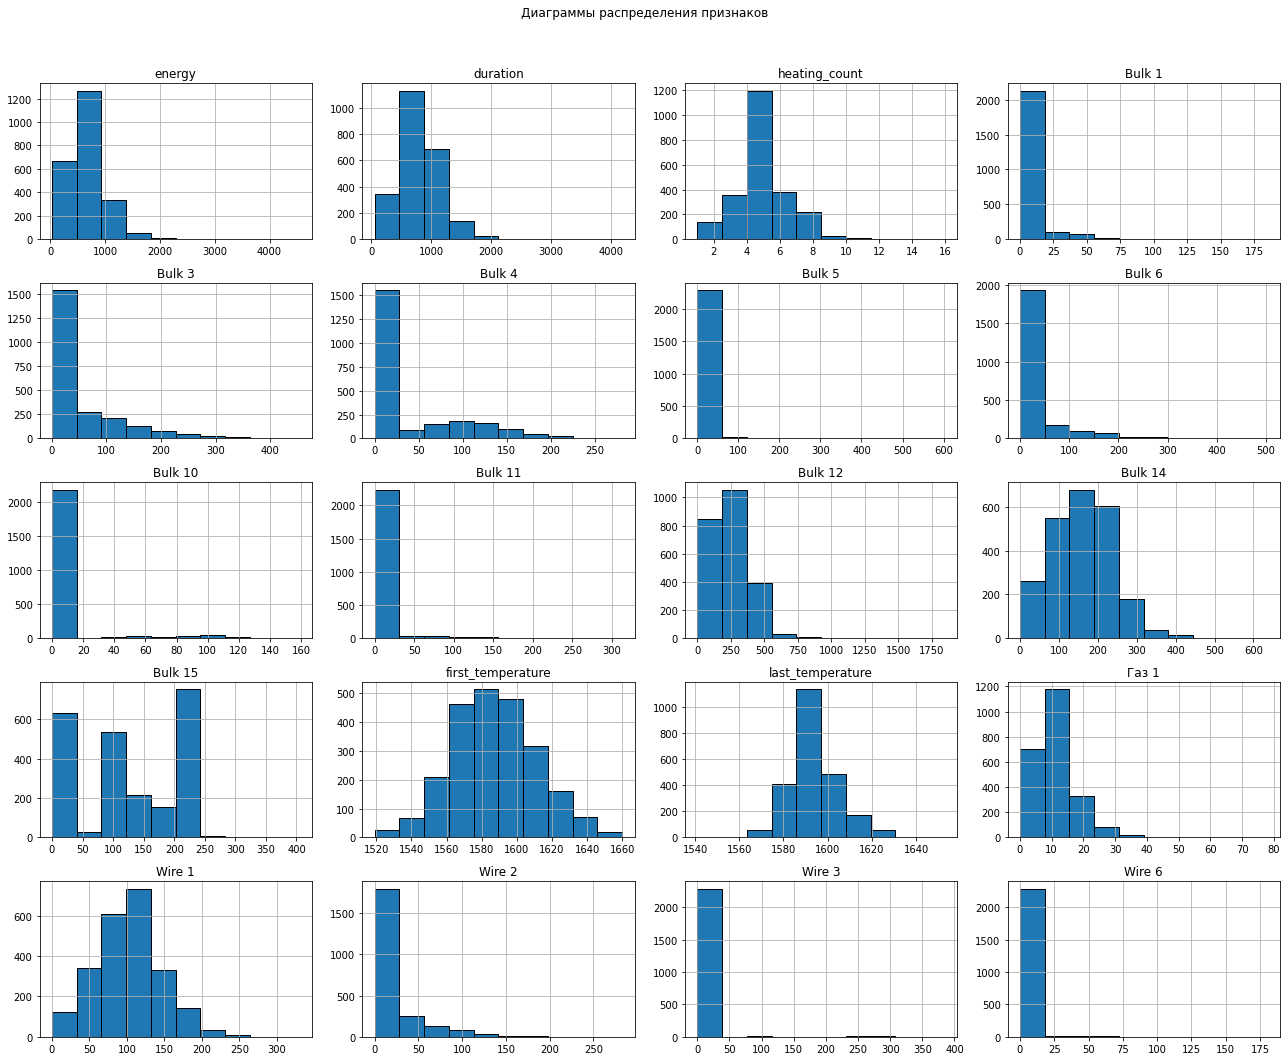

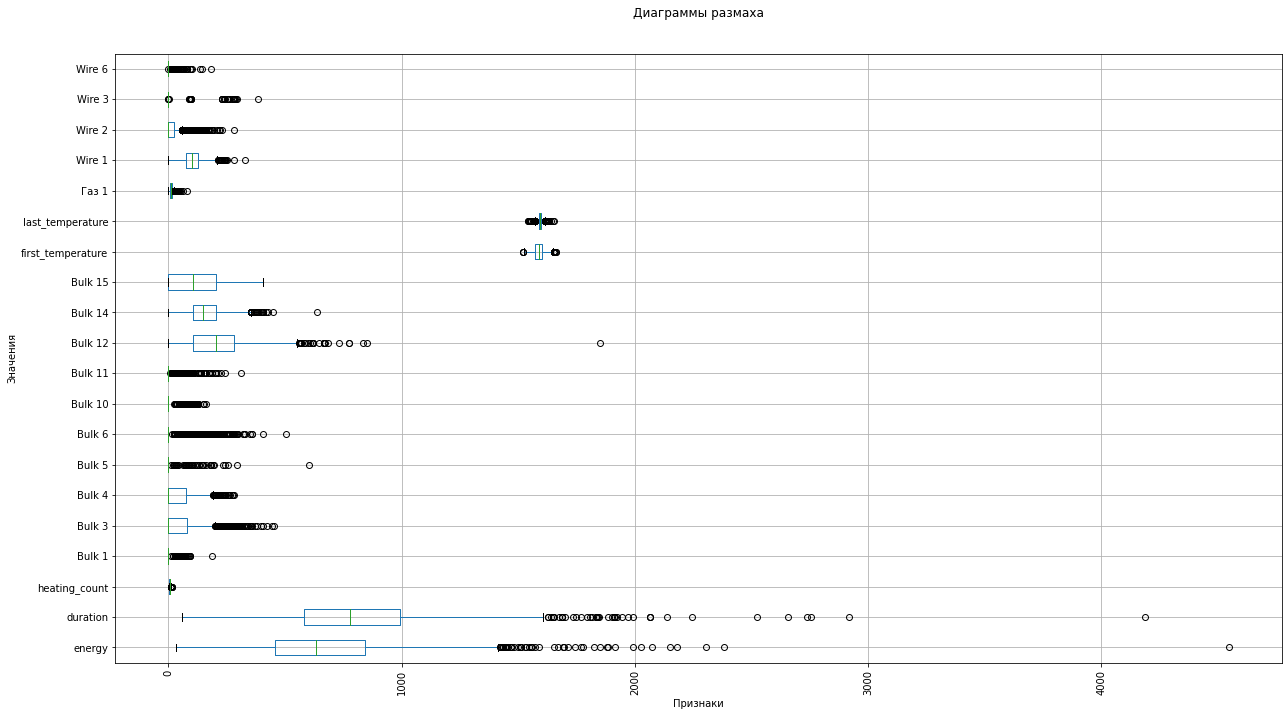

In [56]:
# Построить гистограммы распределения всех признаков
df.hist(bins=10, edgecolor='black', figsize=(18, 14))
plt.tight_layout()
plt.suptitle('Диаграммы распределения признаков', y=1.05)
plt.show()

# Построить ящики с усами для всех признаков
df.boxplot(figsize=(18, 10), vert=False)
plt.xticks(rotation=90)
plt.xlabel('Признаки')
plt.ylabel('Значения')
plt.title('Диаграммы размаха', y=1.05)
plt.tight_layout()
plt.show()


In [57]:
df[df['energy'] > 2000]

,energy,duration,heating_count,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,first_temperature,last_temperature,Газ 1,Wire 1,Wire 2,Wire 3,Wire 6
43,2306.073920,2919.0,13,0.0,0.0,0.0,0.0,70.0,0.0,0.0,204.0,401.0,204.0,1607.0,1612.0,6.118441,100.245593,0.000000,0.000000,0.000000
289,2026.007227,2658.0,13,185.0,101.0,58.0,0.0,0.0,0.0,0.0,1849.0,636.0,0.0,1619.0,1616.0,77.995040,0.000000,188.228550,0.000000,0.000000
393,2181.937459,1490.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,410.0,260.0,152.0,1600.0,1618.0,17.274926,119.199600,67.105999,0.000000,0.000000
416,2074.472552,1925.0,9,0.0,165.0,0.0,0.0,0.0,75.0,0.0,408.0,257.0,153.0,1573.0,1614.0,24.060606,222.955194,0.000000,0.000000,0.000000
1413,2380.879281,2526.0,15,0.0,200.0,0.0,0.0,220.0,0.0,21.0,157.0,180.0,103.0,1553.0,1574.0,38.471706,130.197596,60.229519,0.000000,0.000000
1575,4546.405812,4189.0,15,0.0,0.0,0.0,0.0,247.0,0.0,0.0,733.0,248.0,224.0,1583.0,1606.0,33.597044,187.153206,0.000000,0.000000,0.000000
1969,2151.752807,2739.0,16,63.0,0.0,98.0,94.0,0.0,0.0,0.0,0.0,0.0,0.0,1639.0,1541.0,45.638999,11.051040,0.000000,93.213127,63.045845


In [58]:
df = df.drop('duration', axis=1)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   energy             2325 non-null   float64
 1   heating_count      2325 non-null   int64  
 2   Bulk 1             2325 non-null   float64
 3   Bulk 3             2325 non-null   float64
 4   Bulk 4             2325 non-null   float64
 5   Bulk 5             2325 non-null   float64
 6   Bulk 6             2325 non-null   float64
 7   Bulk 10            2325 non-null   float64
 8   Bulk 11            2325 non-null   float64
 9   Bulk 12            2325 non-null   float64
 10  Bulk 14            2325 non-null   float64
 11  Bulk 15            2325 non-null   float64
 12  first_temperature  2325 non-null   float64
 13  last_temperature   2325 non-null   float64
 14  Газ 1              2325 non-null   float64
 15  Wire 1             2325 non-null   float64
 16  Wire 2             2325 

,energy,heating_count,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,first_temperature,last_temperature,Газ 1,Wire 1,Wire 2,Wire 3,Wire 6
0,770.282114,5,0.0,0.0,43.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0,1571.0,1613.0,29.749986,60.059998,0.00000,0.0,0.0
1,481.760005,4,0.0,0.0,73.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0,1581.0,1602.0,12.555561,96.052315,0.00000,0.0,0.0
2,722.837668,5,0.0,0.0,34.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0,1596.0,1599.0,28.554793,91.160157,0.00000,0.0,0.0
3,683.455597,4,0.0,0.0,81.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0,1601.0,1625.0,18.841219,89.063515,0.00000,0.0,0.0
4,512.169934,4,0.0,0.0,78.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0,1576.0,1602.0,5.413692,89.238236,9.11456,0.0,0.0


### вывод исследование объединенного датасета
- Имеется корреляция между количеством нагревов, длительностью нагревов и энергией затраченной на нагрев. Удалено время нагрева, чтобы избежать мультиколлинеарности, что важно для линейно регрессии.
- присутствует выбросы в признаках, они не являются ошибками - это частные случаи бизнес-процесса (технологического процесса) 
- удалили признак с сильной корреляцией (duration), что важно для линейной регрессии


## Вывод предобработка данных

### df_arc предобработка
- аномалия (отрицательная реактивная мощность -715.479924) восстановлена по средней реактивных мощностей записей в которых активная мощность лежит в диапазоне +- 0,001 от активной мощности записи с аномальным значением реактивной. 
- пропуски отсутствовали
- сформированы новые признаки: 
    - энергия (energy) - произведение полной мощности (корень квадратный из суммы квадратов активной и реактивной мощности) на длительность нагрева)
    - длительность нагрева (duration)
    - количество нагревов (heating_count)
- данные агрегированы по номеру партии (суммарная энергия на каждую партию) и сформирован датасет (df_arc_1) со столбцами: 
    - номер партии (key)
    - энергия (energy)
    - длительность нагрева (duration)
    - количество нагревов (heating_count)
    
###  df_bulk предобработка
- аномалий нет
- пропуски заполнены нулями
- удалены малозначимые партии (использованные в менее чем 26 партиях металла):
  - Bulk 2 - 22 партии
  - Bulk 7 - 25 партий
  - Bulk 8 - 1 партия
  - Bulk 9 - 19 партий
  - Bulk 13 - 18 партий. 
- Сформирован новый датасет (df_bulk_1) с признаками: 'key', 'Bulk 1', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 14', 'Bulk 15'

### df_temp предобработка
- Удалили партии с ошибками измерения температуры (температура < 1300)
- Удалили партии с пропусками в измерении температуры
- Агрегировали по номеру партии и оставили только первый и последний замеры температуры - получили датасет df_temp_1 с признаками:
    - номер партии (key)
    - первая температура (first_temperature)
    - последняя температура (last_temperature)
    
### df_wire предобработка
- аномалий нет
- пропуски заменены нулями
- сформирован новый датасет df_wire_1 с признаками: 'key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 6'

### объединение датасетов
Объединили датасеты в один датасет (df) с признаками:
- energy             
- duration           
- heating_count       
- Bulk 1             
- Bulk 3            
- Bulk 4             
- Bulk 5             
- Bulk 6             
- Bulk 10            
- Bulk 11            
- Bulk 12            
- Bulk 14            
- Bulk 15            
- first_temperature  
- last_temperature   
- Газ 1              
- Wire 1             
- Wire 2             
- Wire 3             
- Wire 6        

### исследование объединенного датасета
- Имеется корреляция между количеством нагревов, длительностью нагревов и энергией затраченной на нагрев. Удалено время нагрева, чтобы избежать мультиколлинеарности.
- присутствует выбросы в признаках, они не являются ошибками - это частные случаи бизнес-процесса (технологического процесса) 
- удалили признак с сильной корреляцией (duration)

# Обучение и выбор лучшей модели
    * разбиение данных на обучающую и тестовую выборки
    * подбор гиперпараметров для нескольких моделей с кроссвалидацией и масштабированием (при необходимости) и определение лучшей
    * проверка качества выбранной лучшей модели на тестовой выборке
    * сранвенние с константной моделью
    * исследование важности признаков

## Выделение таргета, разбиение данных на обучающую и тестовую выборки

In [59]:
y = df['last_temperature']
X = df.drop('last_temperature', axis=1)
    
print('Размер признаков', X.shape)
display(X.head())
print()
print('Размер таргет', y.shape)
display(y.head())

Размер признаков (2325, 18)


,energy,heating_count,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,first_temperature,Газ 1,Wire 1,Wire 2,Wire 3,Wire 6
0,770.282114,5,0.0,0.0,43.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0,1571.0,29.749986,60.059998,0.00000,0.0,0.0
1,481.760005,4,0.0,0.0,73.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0,1581.0,12.555561,96.052315,0.00000,0.0,0.0
2,722.837668,5,0.0,0.0,34.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0,1596.0,28.554793,91.160157,0.00000,0.0,0.0
3,683.455597,4,0.0,0.0,81.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0,1601.0,18.841219,89.063515,0.00000,0.0,0.0
4,512.169934,4,0.0,0.0,78.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0,1576.0,5.413692,89.238236,9.11456,0.0,0.0



Размер таргет (2325,)


0    1613.0
1    1602.0
2    1599.0
3    1625.0
4    1602.0
Name: last_temperature, dtype: float64

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RND)

print('Размер X_train', X_train.shape)
print('Размер y_train', y_train.shape)
print('Размер X_test', X_test.shape)
print('Размер y_test', y_test.shape)

Размер X_train (1743, 18)
Размер y_train (1743,)
Размер X_test (582, 18)
Размер y_test (582,)


Обучим модели. Результаты сохраним в словарь result

In [61]:
result = {}

## LinearRegression

In [62]:
pipeline = Pipeline([
    ("sclr", StandardScaler()),
    ("rgr", LinearRegression())
    ])

params={
     'rgr__normalize' : [True, False],
     'rgr__fit_intercept' : [True, False],
}

gs = GridSearchCV(
        estimator=pipeline,
        param_grid=params,
        n_jobs=-1,
        verbose=1,
        scoring='neg_mean_absolute_error',
        cv=5
    )
gs.fit(X_train, y_train)
print('Лучшие параметры: ', gs.best_params_)
print('MAE: ', - gs.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Лучшие параметры:  {'rgr__fit_intercept': True, 'rgr__normalize': False}
MAE:  6.579927551955275


In [63]:
result['LinearRegression'] = {
    'train MAE' : -gs.best_score_,
    'Лучшие параметры' : gs.best_params_,
    'best_estimator_' : gs.best_estimator_
}

## Ridge

In [64]:
pipeline = Pipeline([
    ("sclr", StandardScaler()),
    ("rgr", Ridge())
    ])

params={
    'rgr__alpha' : list(np.arange(0, 1.5, 0.01)),
    'rgr__random_state' : [RND],
}

gs = GridSearchCV(
        estimator=pipeline,
        param_grid=params,
        n_jobs=-1,
        verbose=1,
        scoring='neg_mean_absolute_error',
        cv=3
    )
gs.fit(X_train, y_train)
print('Лучшие параметры: ', gs.best_params_)
print('MAE: ', - gs.best_score_)

Fitting 3 folds for each of 150 candidates, totalling 450 fits
Лучшие параметры:  {'rgr__alpha': 1.49, 'rgr__random_state': 110923}
MAE:  6.593295823863206


In [65]:
result['Ridge'] = {
    'train MAE' : -gs.best_score_,
    'Лучшие параметры' : gs.best_params_,
    'best_estimator_' : gs.best_estimator_
}

## Lasso

In [66]:
pipeline = Pipeline([
    ("sclr", StandardScaler()),
    ("rgr", Lasso())
    ])

params={
    'rgr__alpha' : list(np.arange(0.01, 1.5, 0.01)),
    'rgr__random_state' : [RND],
}

gs = GridSearchCV(
        estimator=pipeline,
        param_grid=params,
        n_jobs=-1,
        verbose=1,
        scoring='neg_mean_absolute_error',
        cv=3
    )
gs.fit(X_train, y_train)
print('Лучшие параметры: ', gs.best_params_)
print('MAE: ', - gs.best_score_)

Fitting 3 folds for each of 149 candidates, totalling 447 fits
Лучшие параметры:  {'rgr__alpha': 0.18000000000000002, 'rgr__random_state': 110923}
MAE:  6.5611865966032825


In [67]:
result['Lasso'] = {
    'train MAE' : -gs.best_score_,
    'Лучшие параметры' : gs.best_params_,
    'best_estimator_' : gs.best_estimator_
}

## ElasticNet

In [68]:

pipeline = Pipeline([
    ("sclr", StandardScaler()),
    ("rgr", ElasticNet())
    ])

params={
    'rgr__alpha' : list(np.arange(0.01, 1.5, 0.01)),
    'rgr__random_state' : [RND],
}

gs = GridSearchCV(
        estimator=pipeline,
        param_grid=params,
        n_jobs=-1,
        verbose=1,
        scoring='neg_mean_absolute_error',
        cv=3
    )
gs.fit(X_train, y_train)
print('Лучшие параметры: ', gs.best_params_)
print('MAE: ', - gs.best_score_)

Fitting 3 folds for each of 149 candidates, totalling 447 fits
Лучшие параметры:  {'rgr__alpha': 0.09999999999999999, 'rgr__random_state': 110923}
MAE:  6.574876667974274


In [69]:
result['ElasticNet'] = {
    'train MAE' : -gs.best_score_,
    'Лучшие параметры' : gs.best_params_,
    'best_estimator_' : gs.best_estimator_
}

## RandomForestRegressor

In [70]:
pipeline = Pipeline([
#     ("sclr", StandardScaler()),
    ("rgr", RandomForestRegressor())
    ])

params={
    'rgr__random_state' : [RND],
    'rgr__n_estimators' : list(range(500, 1500, 100)),
    'rgr__max_depth': list(range(4, 14, 2))+[None],
    'rgr__max_features': range(2,10,2),
    'rgr__min_samples_split' : range(2,10,2),
    'rgr__min_samples_leaf' : list(range(2, 10, 2)),
}

rs = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=params,
        n_jobs=-1,
        verbose=1,
        scoring='neg_mean_absolute_error',
        cv=3,
        random_state=RND,
        n_iter=40, 
    )
rs.fit(X_train, y_train)
print('Лучшие параметры: ', rs.best_params_)
print('MAE: ', - rs.best_score_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Лучшие параметры:  {'rgr__random_state': 110923, 'rgr__n_estimators': 1100, 'rgr__min_samples_split': 6, 'rgr__min_samples_leaf': 4, 'rgr__max_features': 8, 'rgr__max_depth': 12}
MAE:  6.558490714233287


In [71]:
result['RandomForestRegressor'] = {
    'train MAE' : -rs.best_score_,
    'Лучшие параметры' : rs.best_params_,
    'best_estimator_' : rs.best_estimator_
}

## DecisionTreeRegressor

In [72]:
pipeline = Pipeline([
    ("sclr", StandardScaler()),
    ("rgr", DecisionTreeRegressor())
    ])

params={
    'rgr__random_state' : [RND],
    'rgr__max_depth': list(range(4, 20, 2)),
    'rgr__min_samples_split' : list(range(2, 6)),
    'rgr__min_samples_leaf' : list(range(2, 10, 2)),
}

rs = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=params,
        n_jobs=-1,
        verbose=1,
        scoring='neg_mean_absolute_error',
        cv=3,
        random_state=RND,
        n_iter=40
    )
rs.fit(X_train, y_train)
print('Лучшие параметры: ', rs.best_params_)
print('MAE: ', - rs.best_score_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Лучшие параметры:  {'rgr__random_state': 110923, 'rgr__min_samples_split': 3, 'rgr__min_samples_leaf': 8, 'rgr__max_depth': 6}
MAE:  7.345975380819383


In [73]:
result['DecisionTreeRegressor'] = {
    'train MAE' : -rs.best_score_,
    'Лучшие параметры' : rs.best_params_,
    'best_estimator_' : rs.best_estimator_
}

## CatBoostRegressor

In [74]:
from catboost import CatBoostRegressor
pipeline = Pipeline([
    ("sclr", StandardScaler()),
    ("rgr", CatBoostRegressor())
    ])

params={
    'rgr__random_state' : [RND],
    'rgr__verbose' : [1000],
    'rgr__max_depth': list(range(4, 8, 2)),
    'rgr__loss_function' : ['MAE']
#     'rgr__min_samples_split' : list(range(2, 6)),
#     'rgr__min_samples_leaf' : list(range(1, 10, 2)),
}

gs = GridSearchCV(
        estimator=pipeline,
        param_grid=params,
        n_jobs=-1,
        verbose=1,
        scoring='neg_mean_absolute_error',
        cv=3
    )
gs.fit(X_train, y_train)
print('Лучшие параметры: ', gs.best_params_)
print('MAE: ', - gs.best_score_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
0:	learn: 7.9639175	total: 141ms	remaining: 2m 21s
999:	learn: 4.7468491	total: 3.71s	remaining: 0us
Лучшие параметры:  {'rgr__loss_function': 'MAE', 'rgr__max_depth': 4, 'rgr__random_state': 110923, 'rgr__verbose': 1000}
MAE:  6.337417591260963


In [75]:
result['CatBoostRegressor'] = {
    'train MAE' : -gs.best_score_,
    'Лучшие параметры' : gs.best_params_,
    'best_estimator_' : gs.best_estimator_
}

In [76]:
result_df= pd.DataFrame(result).transpose()

## Лучшая модель

Обучили несколько моделей. Результаты представлены в таблице

In [77]:
result_df

,train MAE,Лучшие параметры,best_estimator_
LinearRegression,6.579928,"{'rgr__fit_intercept': True, 'rgr__normalize': False}","(StandardScaler(), LinearRegression())"
Ridge,6.593296,"{'rgr__alpha': 1.49, 'rgr__random_state': 110923}","(StandardScaler(), Ridge(alpha=1.49, random_state=110923))"
Lasso,6.561187,"{'rgr__alpha': 0.18000000000000002, 'rgr__random_state': 110923}","(StandardScaler(), Lasso(alpha=0.18000000000000002, random_state=110923))"
ElasticNet,6.574877,"{'rgr__alpha': 0.09999999999999999, 'rgr__random_state': 110923}","(StandardScaler(), ElasticNet(alpha=0.09999999999999999, random_state=110923))"
RandomForestRegressor,6.558491,"{'rgr__random_state': 110923, 'rgr__n_estimators': 1100, 'rgr__min_samples_split': 6, 'rgr__min_...","((DecisionTreeRegressor(max_depth=12, max_features=8, min_samples_leaf=4,\n ..."
DecisionTreeRegressor,7.345975,"{'rgr__random_state': 110923, 'rgr__min_samples_split': 3, 'rgr__min_samples_leaf': 8, 'rgr__max...","(StandardScaler(), DecisionTreeRegressor(max_depth=6, min_samples_leaf=8, min_samples_split=3,\n..."
CatBoostRegressor,6.337418,"{'rgr__loss_function': 'MAE', 'rgr__max_depth': 4, 'rgr__random_state': 110923, 'rgr__verbose': ...","(StandardScaler(), <catboost.core.CatBoostRegressor object at 0x000002257A908070>)"


Лучший показатель MAE = 6.337418 у модели CatBoostRegressor со следующими праметрами:


CatBoostRegressor(loss_function = 'MAE', max_depth=4, random_state=110923)

## Проверка качества выбранной лучшей модели на тестовой выборке

In [78]:
best_model = result['CatBoostRegressor']['best_estimator_']
y_pred = best_model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred)
print('MAE на тестовой выборке', mae_test)


MAE на тестовой выборке 6.794347646392389


### вывод проверка качества выбранной лучшей модели на тестовой выборке
Метрика качества MAE (средняя абсолютная ошибка) на тестовой выборке составлиа 6,79, что означает среднюю ошибку предсказания температуры в 6,79 градуса.

## Cравненние с константной моделью

In [79]:
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(X_train, y_train)
y_pred_dummy = dummy_model.predict(X_test)
mae_dummy_mean = mean_absolute_error(y_test, y_pred_dummy)

dummy_model = DummyRegressor(strategy="median")
dummy_model.fit(X_train, y_train)
y_pred_dummy = dummy_model.predict(X_test)
mae_dummy_median = mean_absolute_error(y_test, y_pred_dummy)

print("Mean Absolute Error (константная модель (средняя температура)):", mae_dummy_mean)
print("Mean Absolute Error (константная модель (медианная температура)):", mae_dummy_median)
print("Mean Absolute Error (лучшая модель):", mae_test)

Mean Absolute Error (константная модель (средняя температура)): 8.238817814212164
Mean Absolute Error (константная модель (медианная температура)): 8.207903780068728
Mean Absolute Error (лучшая модель): 6.794347646392389


### вывод сравненние с константной моделью
Константная модель выдающая среднюю температуру в качестве предсказания имеет MAE = 8.24


Константная модель выдающая среднюю температуру в качестве предсказания имеет MAE = 8.21


В то же время выбранная нами лучшая модель показывает лучший результат с MAE = 6.79

## Исследование важности признаков

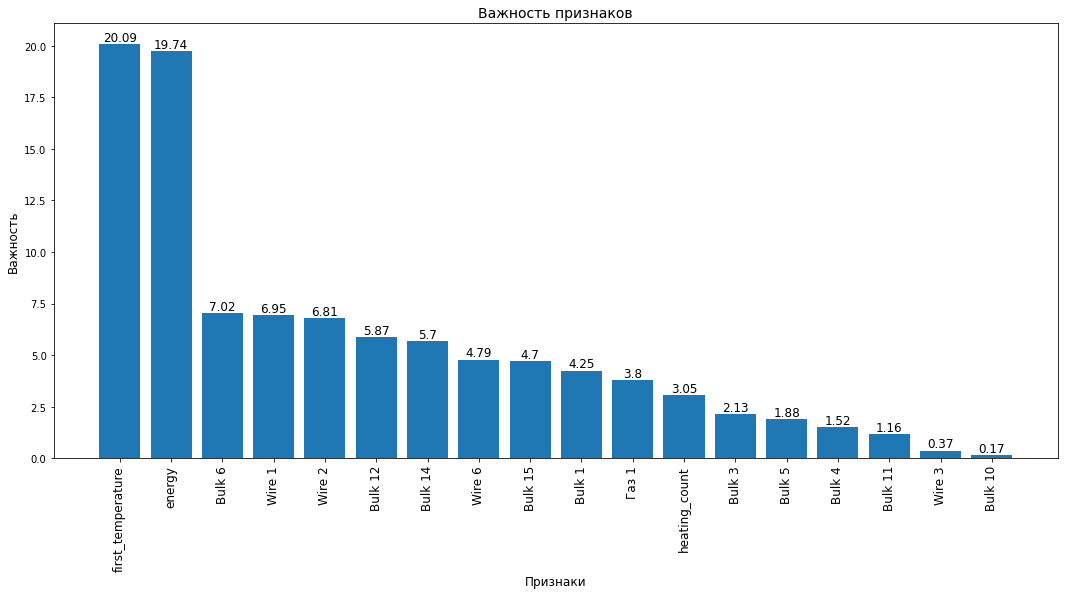

In [80]:
# Получение важности признаков
feature_importance = best_model['rgr'].get_feature_importance()

# Создаем список с названиями признаков
feature_names = X_train.columns.tolist()

# Получение индексов, сортированных по убыванию важности
sorted_indexes = feature_importance.argsort()[::-1]

# Сортировка значений важности и названий признаков по убыванию
sorted_feature_importance = feature_importance[sorted_indexes]
sorted_feature_names = np.array(feature_names)[sorted_indexes]

# Построение диаграммы
plt.figure(figsize=(18,8))
plt.bar(sorted_feature_names, sorted_feature_importance)
plt.xticks(rotation=90, fontsize=12)
plt.xlabel('Признаки', fontsize=12)
plt.ylabel('Важность', fontsize=12)
plt.title('Важность признаков', fontsize=14)

# Добавление значений на диаграмму
for i, v in enumerate(sorted_feature_importance):
    plt.text(i, v, str(round(v, 2)), ha='center', va='bottom', fontsize=12)
    
plt.show()

Из диаграммы видна важность признаков для предсказания температуры моделью. Перечислим наиболее важные (вносящие наибольший вклад в предсказание):
1. first_temperature - Исходная температура (первый замер температуры) - важность 20,09
2. energy - энергия затраченная на нагрев - важность 19.74
3. Bulk 6 - важность 7.02
4. Wire 1 - важность 6.95
4. Wire 2 - важность 6.81

## Вывод обучение и выбор лучшей модели

Обучили несколько моделей. Результаты представлены в таблице

In [81]:
result_df

,train MAE,Лучшие параметры,best_estimator_
LinearRegression,6.579928,"{'rgr__fit_intercept': True, 'rgr__normalize': False}","(StandardScaler(), LinearRegression())"
Ridge,6.593296,"{'rgr__alpha': 1.49, 'rgr__random_state': 110923}","(StandardScaler(), Ridge(alpha=1.49, random_state=110923))"
Lasso,6.561187,"{'rgr__alpha': 0.18000000000000002, 'rgr__random_state': 110923}","(StandardScaler(), Lasso(alpha=0.18000000000000002, random_state=110923))"
ElasticNet,6.574877,"{'rgr__alpha': 0.09999999999999999, 'rgr__random_state': 110923}","(StandardScaler(), ElasticNet(alpha=0.09999999999999999, random_state=110923))"
RandomForestRegressor,6.558491,"{'rgr__random_state': 110923, 'rgr__n_estimators': 1100, 'rgr__min_samples_split': 6, 'rgr__min_...","((DecisionTreeRegressor(max_depth=12, max_features=8, min_samples_leaf=4,\n ..."
DecisionTreeRegressor,7.345975,"{'rgr__random_state': 110923, 'rgr__min_samples_split': 3, 'rgr__min_samples_leaf': 8, 'rgr__max...","(StandardScaler(), DecisionTreeRegressor(max_depth=6, min_samples_leaf=8, min_samples_split=3,\n..."
CatBoostRegressor,6.337418,"{'rgr__loss_function': 'MAE', 'rgr__max_depth': 4, 'rgr__random_state': 110923, 'rgr__verbose': ...","(StandardScaler(), <catboost.core.CatBoostRegressor object at 0x000002257A908070>)"


Лучший показатель MAE = 6.337418 у модели CatBoostRegressor со следующими праметрами:

CatBoostRegressor(loss_function = 'MAE', max_depth=4, random_state=110923)

Метрика качества MAE (средняя абсолютная ошибка) на тестовой выборке составлиа 6,79, что означает среднюю ошибку предсказания температуры в 6,79 градуса.

Константная модель выдающая медианную температуру в качестве предсказания имеет MAE = 8.21, что хуже чем лучшая модель, обученная нами.

Исследована важность признаков, наиболее важными являются:
1. first_temperature - Исходная температура (первый замер температуры) - важность 20,09
2. energy - энергия затраченная на нагрев - важность 19.74
3. Bulk 6 - важность 7.02
4. Wire 1 - важность 6.95
4. Wire 2 - важность 6.81

# Отчет
    * сравнение решения и плана
    * описание трудностей проекта
    * ключевые шаги решения
    * признаки, которые использовали для обучения и их обработка
    * полное описание модели (с гиперпараметрами, включая random_state, если использовался)
    * итоговая метрика
    * рекомендации по улучшению решения

## Описание
В рамках проекта необходимо было построить модель для предсказания температуры расплава. 

**Описание тех.процесса:**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Описание данных**

Данные состоят из файлов, полученных из разных источников:
- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. 

В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.


## Cравнение решения и плана

Для решения поставленной задачи был составлен следующий план:

### План работ:
#### Описание проекта
##### Знакомство c данными и исследование данных
    
    * загрузка данных
    * исследование данных
        * изучение структуры данных (shape, info)
        * изучение содержимого данных (несколько строк)
        * изучение на предмет пропусков значений
        * проверка на наличие дубликатов
        * визуализация данных (при необходимости)
        * выявление аномалий 
        * проверка наличия корреляций (при необходмости)
#### Предобработка данных
    * обработка выбросов, аномалий
    * обработка пропусков
    * генерация новых признаков (при необходимости)
    * агрегирование данных по номеру партии
    * объединение в один датафрейм
    * исследование объединенного датафрейма
        * проверка наличия корреляций
#### Обучение и выбор лучшей модели
    * разбиение данных на обучающую и тестовую выборки
    * подбор гиперпараметров для нескольких моделей с кроссвалидацией и масштабированием (при необходимости) и определение лучшей
    * проверка качества выбранной лучшей модели на тестовой выборке
    * сравненние с константной моделью
    * исследование важности признаков
#### Отчет
    * сравнение решения и плана
    * описание трудностей проекта
    * ключевые шаги решения
    * признаки, которые использовали для обучения и их обработка
    * полное описание модели (с гиперпараметрами, включая random_state, если использовался)
    * итоговая метрика
    * рекомендации по улучшению решения
    
    
**Работа выполнена в соответствии с планом**    

## Описание трудностей проекта

Выполнение проекта не вызвало особых трудностей, в то же вермя следует отметить следующие моменты:
- наличие в исходных данных большого количества пропусков
- присутствие выбросов в некоторых признаках, часть из которых являлись ошибками, а часть - частными случаями тех.процесса
- необходимость построения дополнительных признаков на основе имеющихся, для достижения приемлемого качества результатов модели

## Ключевые шаги решения
В ходе решения, как указано в плане были выполнены следующие ключевые шаги:
- **знакомство и исследование данных**, в ходе которого расмотрены:
    - структура и объем данных
    - наличие пропусков и дубликатов
    - наличие выбросов (аномалий)
    - распределение данных
- **предобработка данных**, в ходе которого выполенно:
    - обработка выбросов, аномалий: 
        - удаление партий металла с аномально низкими температурами
        - восстановление аномальной (отрицательной) реактивной мощности
        - удалены редко используемые материалы:
            - Wire 4 - 14 партий
            - Wire 5 - 1 партия
            - Wire 7 - 11 партий
            - Wire 8 - 19 партий
            - Wire 9 - 29 партий
            - Bulk 2 - 22 партии
            - Bulk 7 - 25 партий
            - Bulk 8 - 1 партия
            - Bulk 9 - 19 партий
            - Bulk 13 - 18 партий
    - обработка пропусков:
        - замена пропусков нулями в сыпучих и проволчных материалах
        - удаление партий с пропусками измерения температуры и наличием только одного измерения
    - генерация новых признаков (при необходимости):
        - энергия (energy) - произведение полной мощности (корень квадратный из суммы квадратов активной и реактивной мощности) на длительность нагрева)
        - длительность нагрева (duration)
        - количество нагревов (heating_count)
    - агрегирование данных по номеру партии
        - выделена первая и последняя измеренная температура по партии
        - посчитана суммарная энергия, длительность нагрева и количество нагревов по партии
    - объединение в один датафрейм
        - данные объединены в один датарейм по номеру партии (внутренне объединение - в итоговом датафрейме содержатся данные тех партий, которые были во всех датасетах)
    - исследование объединенного датафрейма
        - проверка наличия корреляций (удалены признаки имеющие сильную корреляцию (коэф. кореляции > 0.9): duration - время нагрева)
- **Обучение и выбор лучшей модели**
    - разбиение данных на обучающую и тестовую выборки (коэф. разбиения 0.25)
    - подбор гиперпараметров для нескольких моделей с кроссвалидацией и масштабированием и определение лучшей:
        - подбор гиперпараметров с помощью GridSearchCV, RandomizedSearchCV с масштабированием StandardScaler в pipeline, cv = 3
        результаты представлены в таблице:

In [82]:
result_df

,train MAE,Лучшие параметры,best_estimator_
LinearRegression,6.579928,"{'rgr__fit_intercept': True, 'rgr__normalize': False}","(StandardScaler(), LinearRegression())"
Ridge,6.593296,"{'rgr__alpha': 1.49, 'rgr__random_state': 110923}","(StandardScaler(), Ridge(alpha=1.49, random_state=110923))"
Lasso,6.561187,"{'rgr__alpha': 0.18000000000000002, 'rgr__random_state': 110923}","(StandardScaler(), Lasso(alpha=0.18000000000000002, random_state=110923))"
ElasticNet,6.574877,"{'rgr__alpha': 0.09999999999999999, 'rgr__random_state': 110923}","(StandardScaler(), ElasticNet(alpha=0.09999999999999999, random_state=110923))"
RandomForestRegressor,6.558491,"{'rgr__random_state': 110923, 'rgr__n_estimators': 1100, 'rgr__min_samples_split': 6, 'rgr__min_...","((DecisionTreeRegressor(max_depth=12, max_features=8, min_samples_leaf=4,\n ..."
DecisionTreeRegressor,7.345975,"{'rgr__random_state': 110923, 'rgr__min_samples_split': 3, 'rgr__min_samples_leaf': 8, 'rgr__max...","(StandardScaler(), DecisionTreeRegressor(max_depth=6, min_samples_leaf=8, min_samples_split=3,\n..."
CatBoostRegressor,6.337418,"{'rgr__loss_function': 'MAE', 'rgr__max_depth': 4, 'rgr__random_state': 110923, 'rgr__verbose': ...","(StandardScaler(), <catboost.core.CatBoostRegressor object at 0x000002257A908070>)"


## Признаки, которые использовали для обучения и их обработка

Для обучения были использованы признаки 
- energy  - энергия: произведение полной мощности (корень квадратный из суммы квадратов активной и реактивной мощности) на длительность нагрева)
- heating_count - количество нагревов      2325 non-null   int64  
- Bulk 1, Bulk 3, Bulk 4, Bulk 5, Bulk 6, Bulk 10, Bulk 11, Bulk 12, Bulk 14, Bulk 15 - объемы сыпучих материалов
- first_temperature - первая измеренная температура по партии
- last_temperature - последняя измеренная температура по партии
- Газ 1 - данные о продувке газом
- Wire 1, Wire 2, Wire 3, Wire 6 - объемы проволочных материалов
Признаки были масштабированы с помощью StandardScaler в пайплайне

## Полное описание модели (с гиперпараметрами, включая random_state, если использовался)

Лучшая модель:

CatBoostRegressor(loss_function = 'MAE', max_depth=4, random_state=110923)

## Итоговая метрика

MAE на обучающей выборке = 6.337418

MAE на тестовой выборке составлиа 6,79

MAE константной модели (медиана температур) = 8.21, что хуже чем лучшая модель, обученная нами.

## Рекомендации по улучшению решения

Улучшить метрику можно: 
- добавив больше синтетических признаки: средняя длительность нагрева, средняя энергия на нагрев, средняя активная мощность, количество добавляемых материалов, средний объем добавляемых материалов и т.д.
- увеличить количество фолдов в кросс-валидации
- изменить сетку подбора гиперпараметров.